In [1]:

import jax
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
print(jax.local_devices())



import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

[cuda(id=0)]


In [2]:
def compute_1d_error(pred, u, x, y):
    norm_u = jnp.sqrt(integrate.trapezoid(u**2, x))
    norm_diff = jnp.sqrt(integrate.trapezoid((pred - u)**2, x))
    return norm_diff, norm_diff/norm_u

# Using the DST for solving an elliptic PDE

We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + u &= \xi \\
u &= 0
\end{aligned}


If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Conversely, if 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty \xi_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

then 

$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)} \sin\Big(\frac{n\pi x}{L}\Big)
$$

Iou casem we will have the domain be $[0,1]$ and so $L = 1.0$. Therefore

\begin{aligned}
\xi &=   \sqrt{2} \sum_{i}^\infty \xi_i \sin\Big(n\pi x\Big) \\
u &=  \sqrt{2}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)}\sin\Big(n\pi x\Big)
\end{aligned}


In [3]:
plt.style.use('plot_style-Examples.txt')
#plt.style.use('default')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [4]:
from importlib import reload
import utils_DST

utils_DST = reload(utils_DST)
from utils_DST import discrete_sine_transform

In [5]:
key = random.PRNGKey(635)
nu = 0.01


n_coef = 2**14
upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef+1, endpoint=False)[1:] # Do not include 0 or 1!
print(n_coef)

frequencies = jnp.arange(0, n_coef) + 1
coef_f = jnp.hstack([random.normal(key, shape= (n_coef,))]) # We set the first coefficient to zero as it corresponds to the constant term
coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 + 1)

f_values = discrete_sine_transform(coef_f)
u_values = discrete_sine_transform(coef_u)

16384


In [6]:
# # Sanity check
# def evaluate_function_sine(x, k ,c):
#     return c*jnp.sqrt(2)*jnp.sin(jnp.pi*k*x)
# def evaluate_basis_sine(x,c):
#     # The frequency starts at 0
#     frequencies = jnp.arange(0, c.shape[0]) + 1
#     return jnp.sum(vmap(evaluate_function_sine, in_axes=(0,None,None))(x, frequencies, c), axis=1)

# f_manual = evaluate_basis_sine(domain_finest, coef_f)
# u_manual = evaluate_basis_sine(domain_finest, coef_u)

# print(jnp.mean(jnp.abs(f_values - f_manual)), jnp.mean(jnp.abs(u_manual - u_values)))

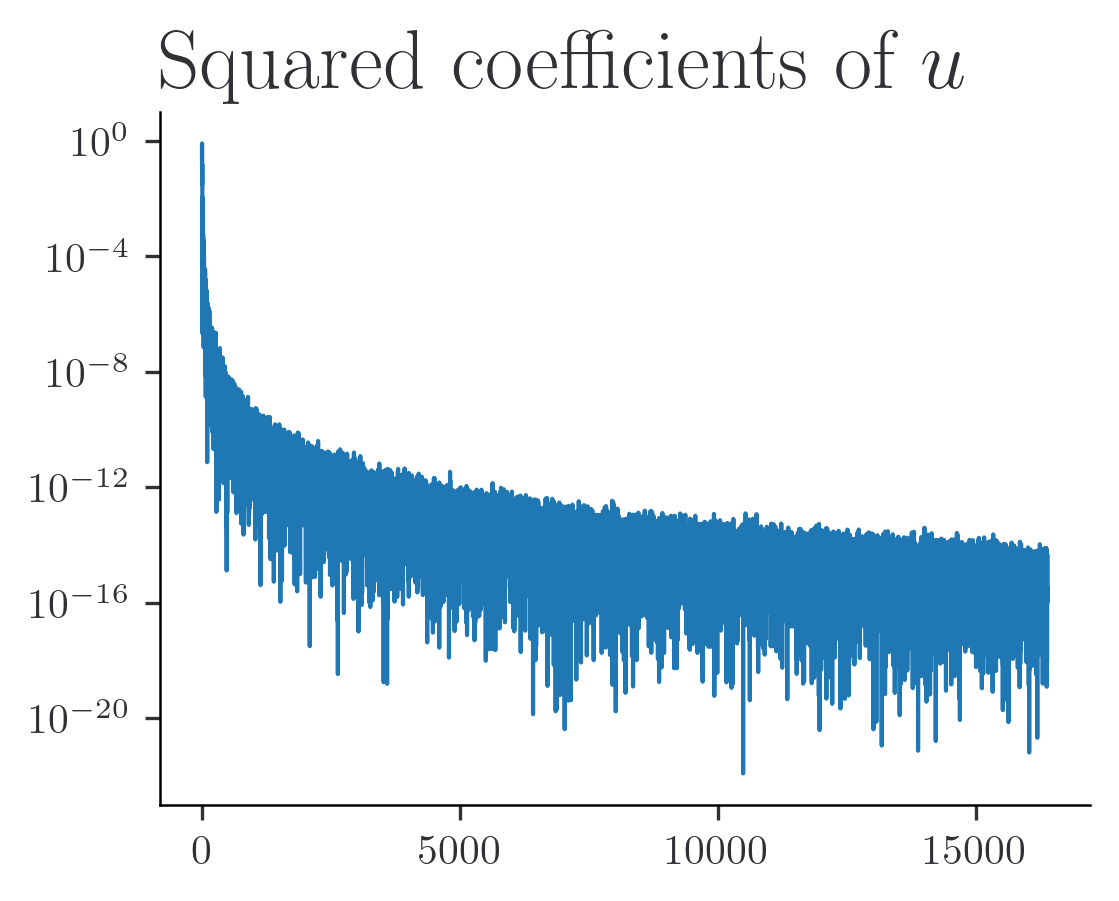

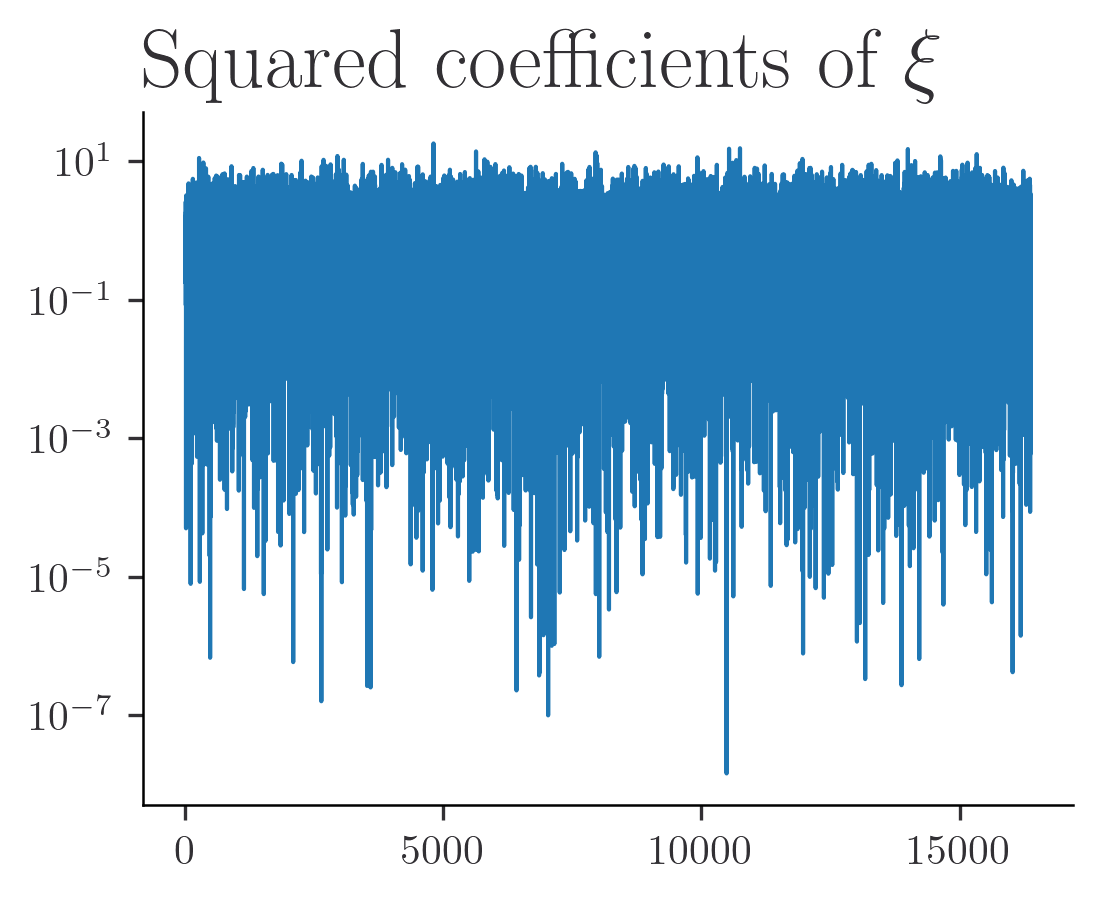

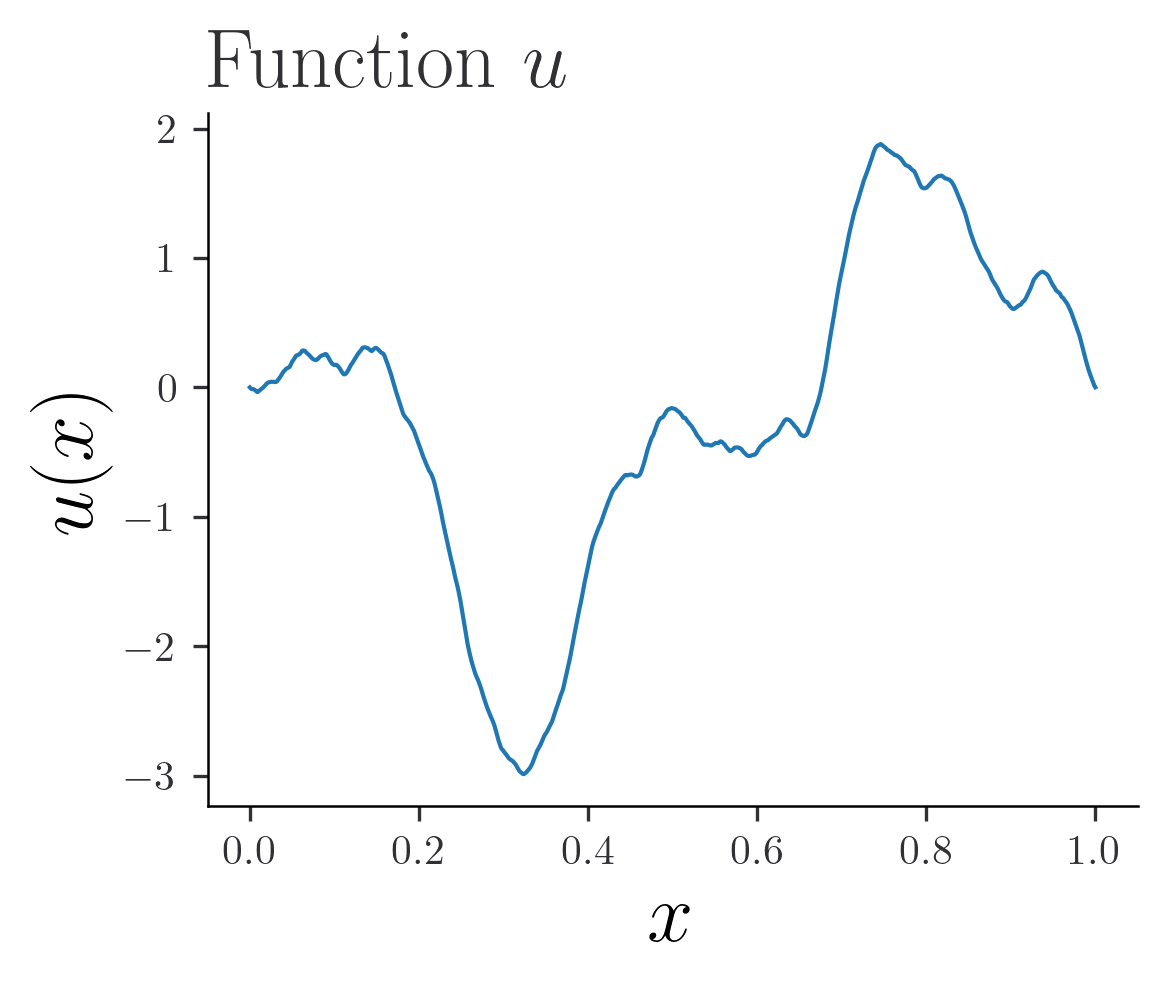

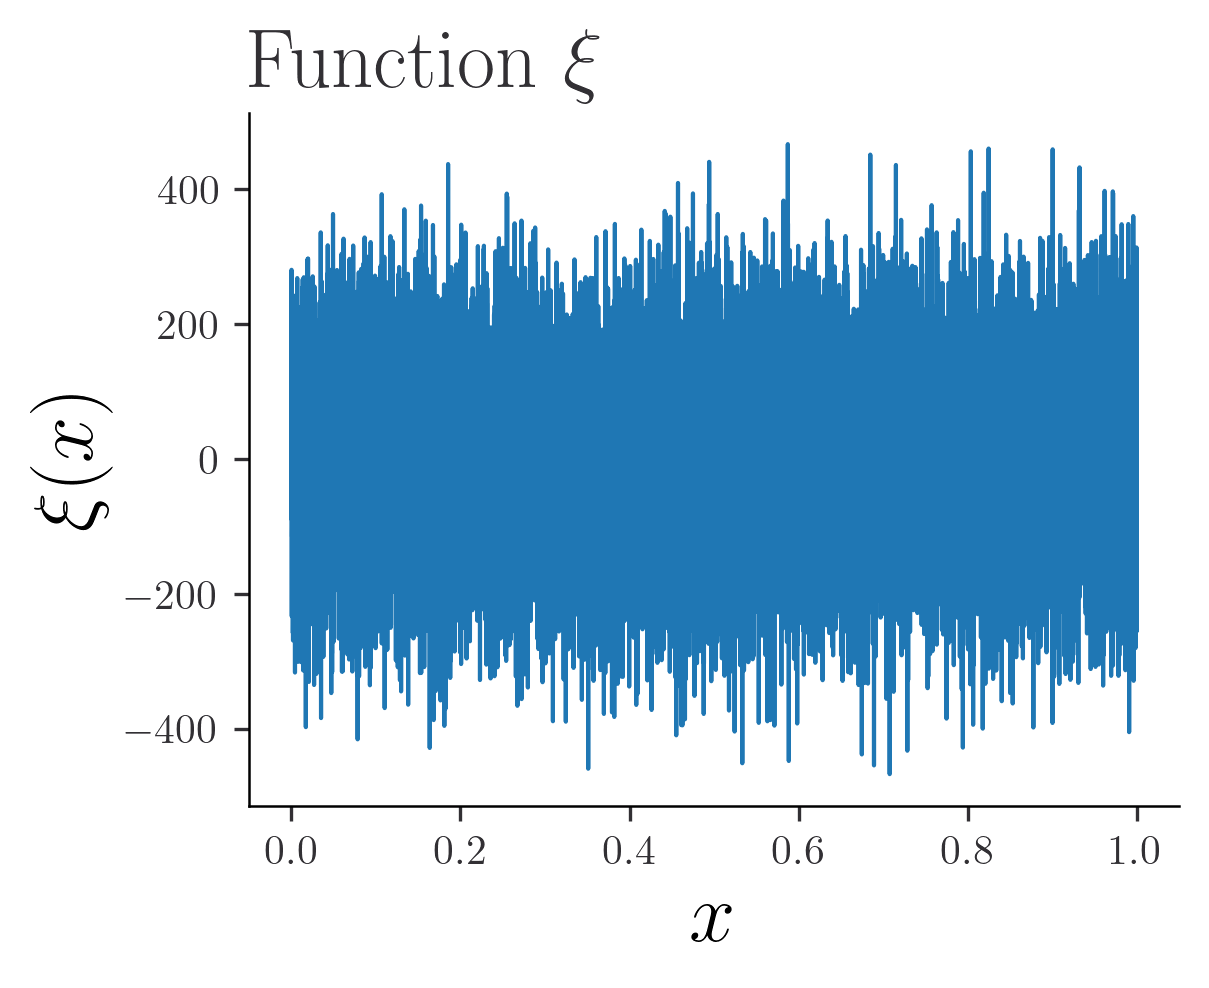

In [7]:
# Plot both the coeffients of u and f in 2 subplots
fig = plt.figure(figsize=(width, height))
plt.plot(coef_u**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $u$')


plt.show()

fig = plt.figure(figsize=(width, height))
plt.plot(coef_f**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $\xi$')
plt.show()

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, u_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")

fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, f_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$\xi(x)$")
plt.title(r"Function $\xi$")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

# Computing a solution

In [8]:
from utils_elliptic_coef import L_b_xy, vmap_L_b_xy, vmap_L_b_y
b =lambda x : jnp.ones_like(x)*1.0

In [9]:
coef_f.shape

(16384,)

In [9]:
coef_f

Array([-0.42401272, -1.265321  ,  0.80601752, ...,  1.32265504,
        0.26745439,  0.47165721], dtype=float64)

In [11]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
length_scale = 1.0

4096


In [12]:
# Build the kernel matrix
theta_11 = vmap_kernel(boundary, boundary, length_scale)
theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))

In [13]:
from importlib import reload
import utils_DST

utils_DST = reload(utils_DST)
from utils_DST import discrete_sine_transform, vmap_dst, vmap_compute_sine_coef, compute_sine_coefficients

In [14]:
theta_22_sine = vmap_compute_sine_coef(vmap_compute_sine_coef(theta_22).T)
theta_22_sine = theta_22_sine
theta_12_sine = vmap_compute_sine_coef(theta_12)
theta_12_sine = theta_12_sine
theta = jnp.block([[theta_11, theta_12_sine], [theta_12_sine.T, theta_22_sine]])

In [15]:
jnp.linalg.eigh(theta)[0][0] # This is PSD!

Array(4.44050438e-10, dtype=float64)

In [57]:
reg = 1e-14
decay = jnp.arange(n_meas) +1
s_decay = 1.0
rhs = jnp.concatenate([jnp.zeros_like(boundary), coef_f[:n_meas]])
nugget = jnp.concatenate([jnp.zeros_like(boundary), reg*decay**s_decay])
alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a="pos") # Solve the linear system

In [58]:
K = vmap_kernel(domain_finest, boundary, length_scale)
K_interior = vmap_compute_sine_coef(vmap_L_b_y(domain_finest, domain_measurements, length_scale, nu, b(domain_measurements)))
K_interior = K_interior# remove the last spurious element
K_eval = jnp.block([K, K_interior])
pred = K_eval@alpha

In [59]:
# Computing the error in the Fourier domain
pred_transform = compute_sine_coefficients(pred)
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)

4.921089355621577e-05 3.954325855759526e-05


In [22]:
compute_1d_error(pred, u_values, domain_finest, domain_measurements)

(Array(0.00084506, dtype=float64), Array(0.00067904, dtype=float64))

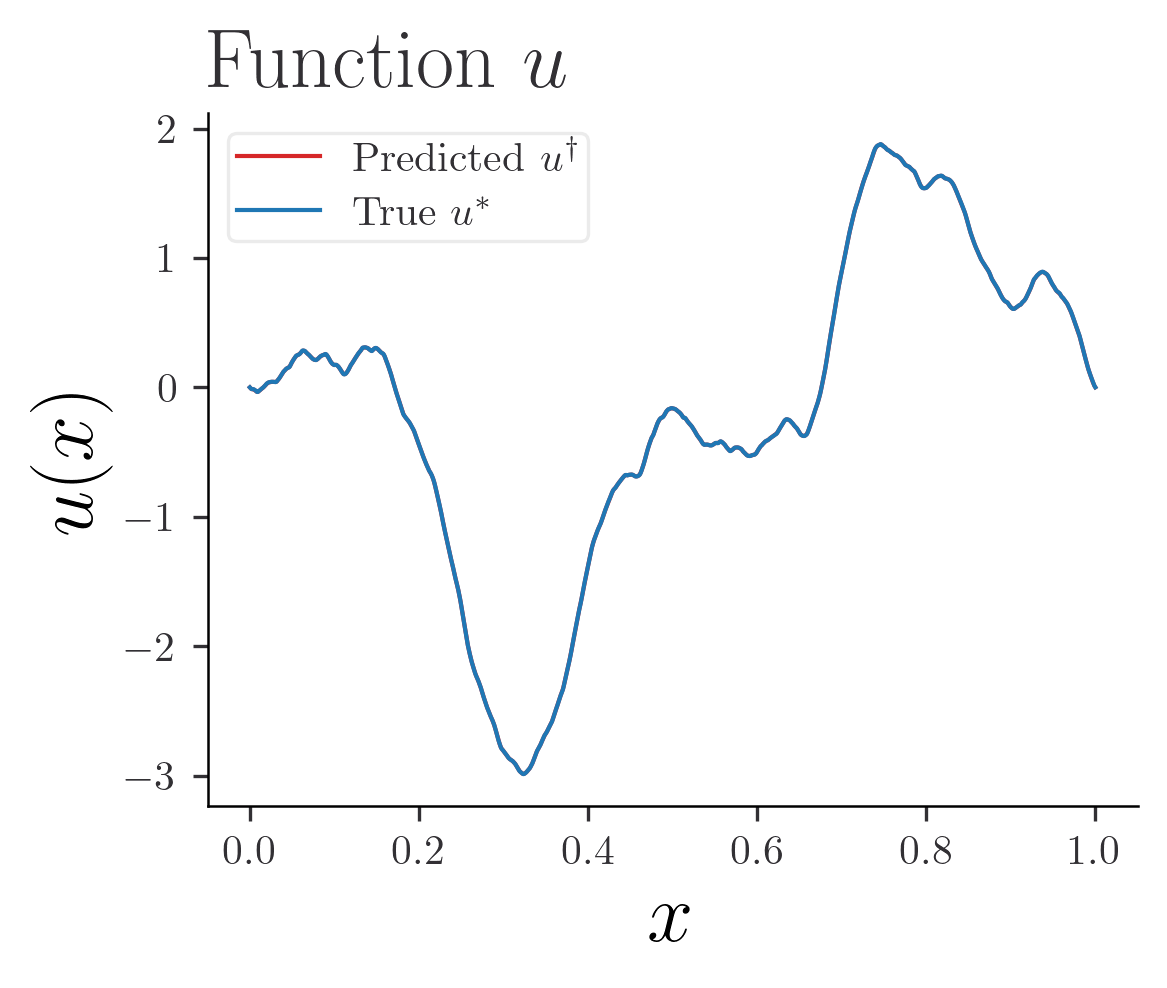

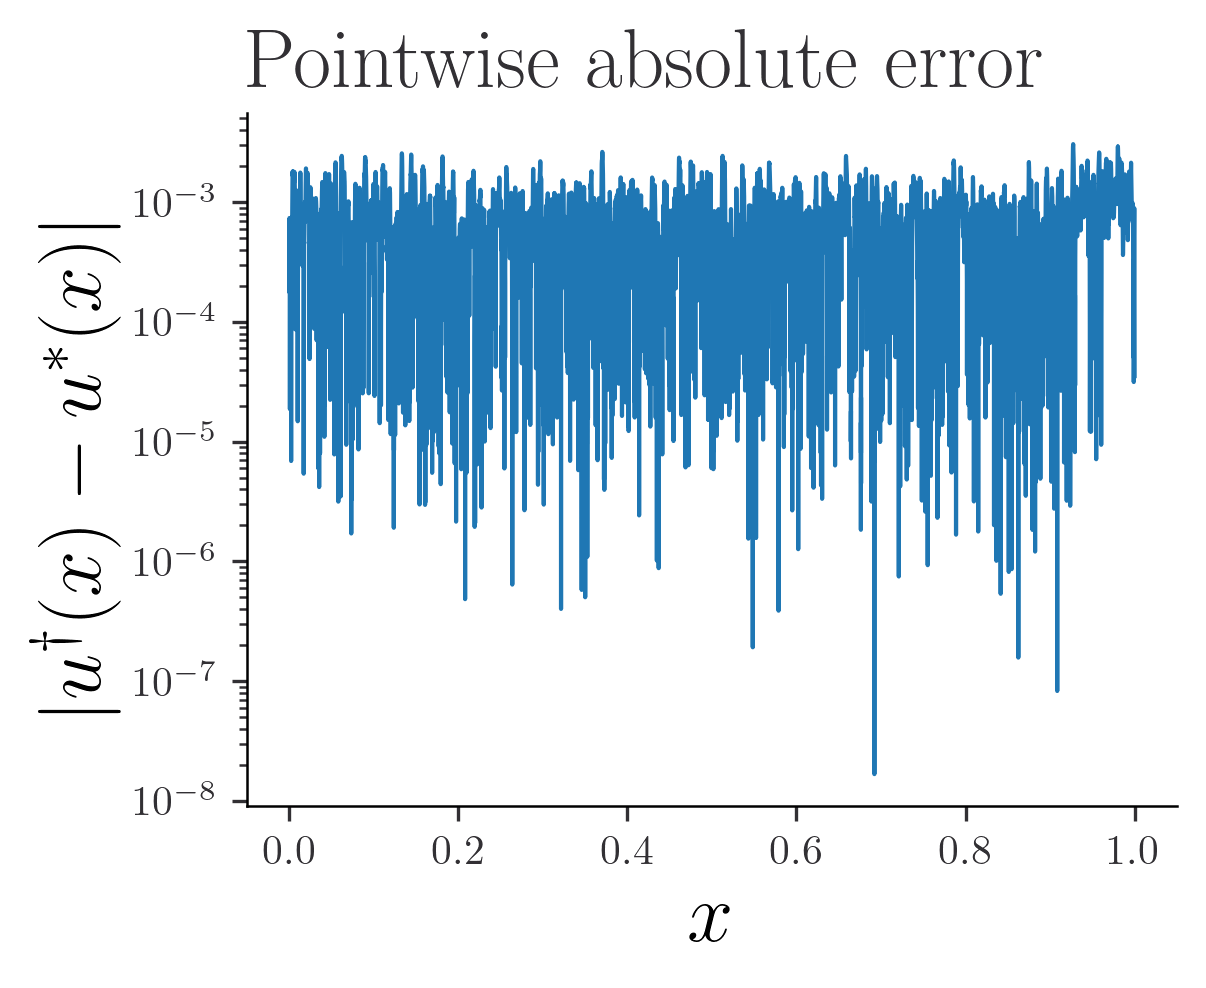

In [23]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


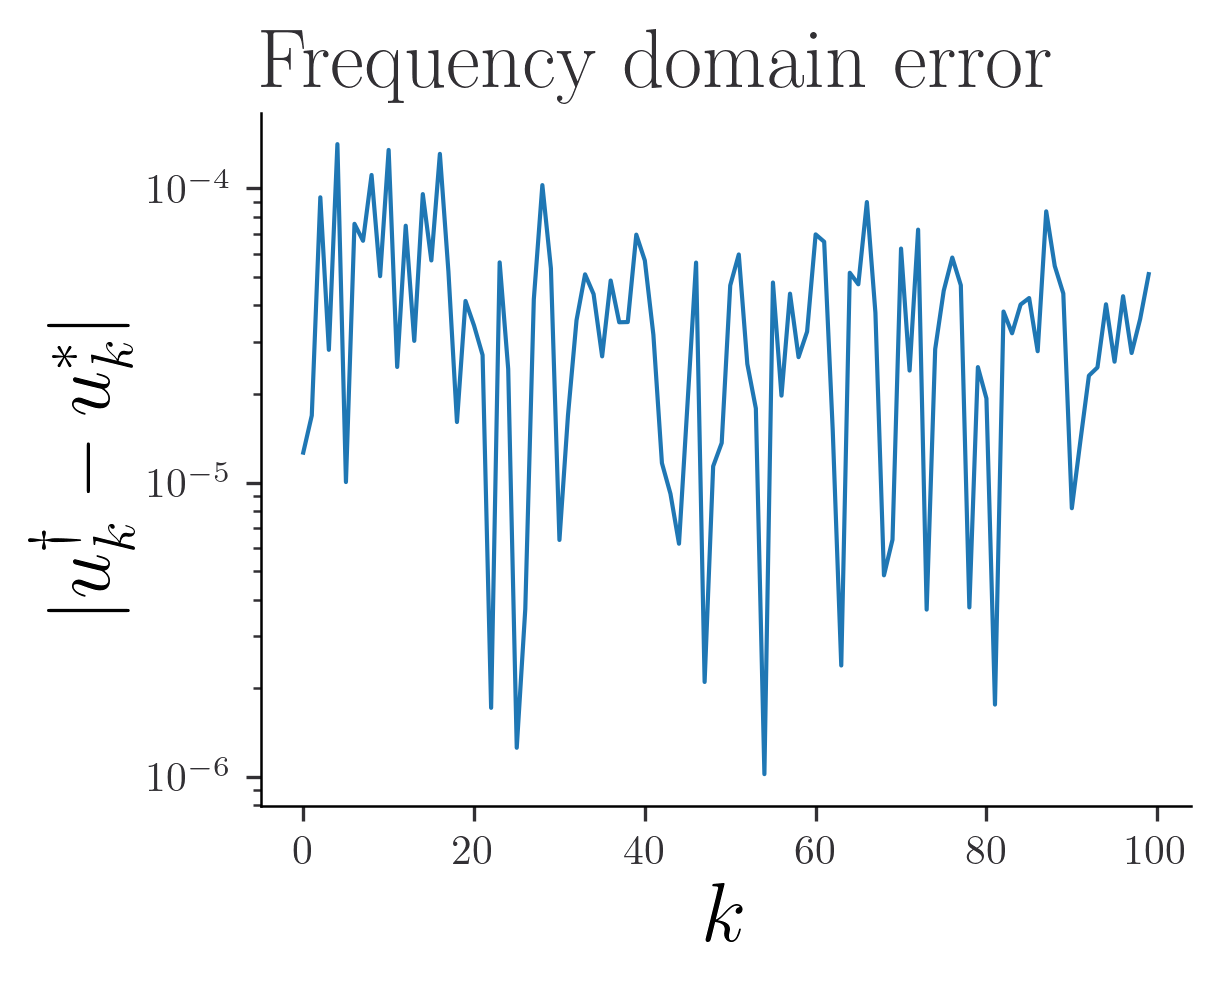

In [24]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

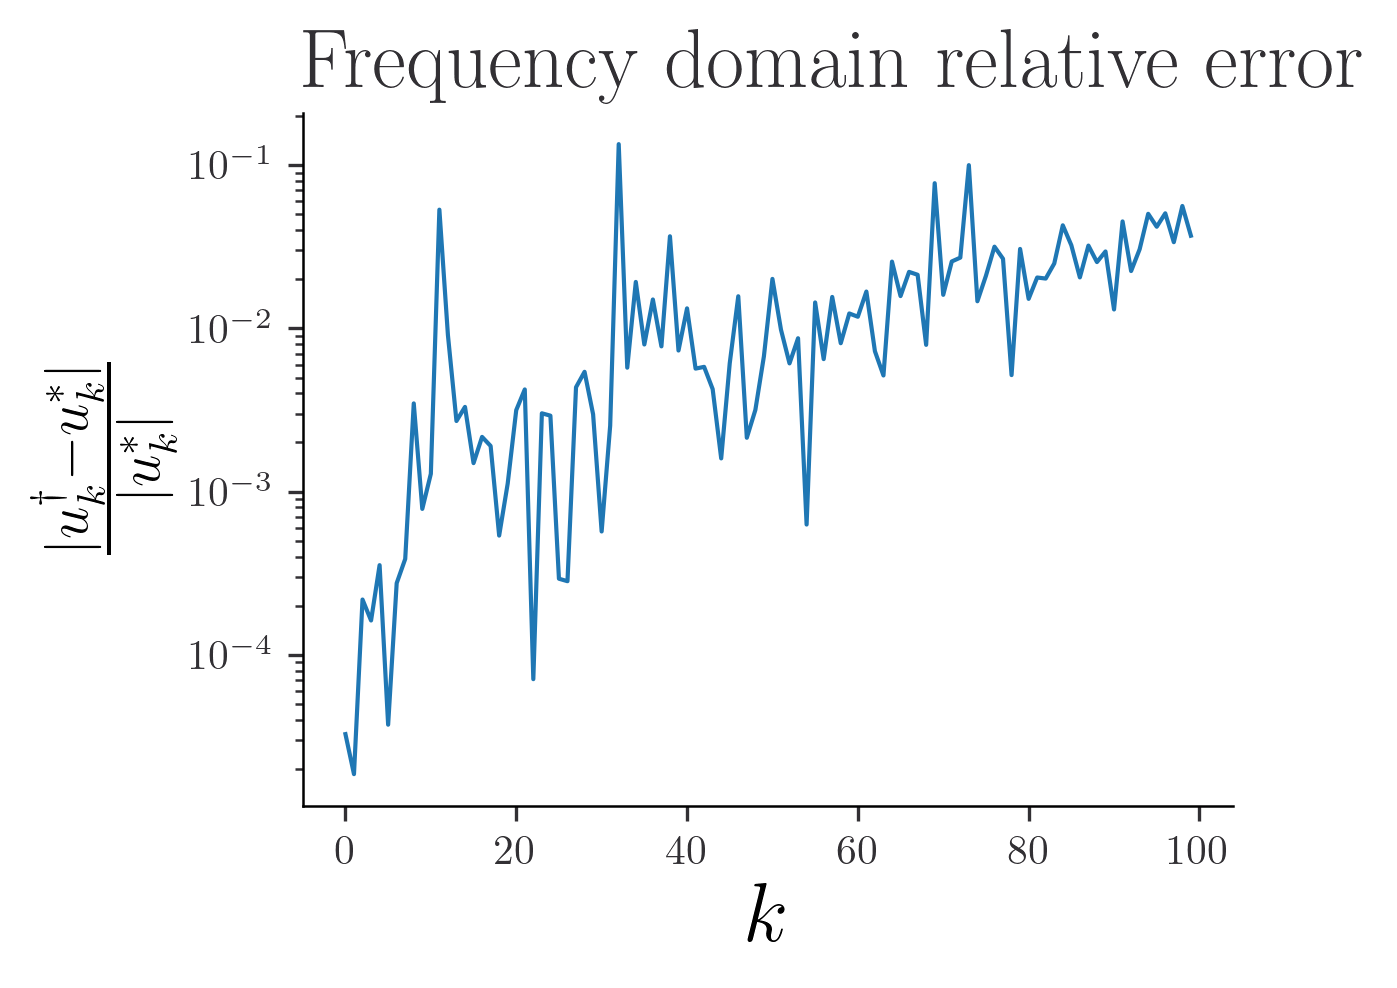

In [25]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# Computing error rates

In [26]:
# coef_eval = coef_u[:n_eval]
# ratio = int(n_coef/n_eval)
# u_eval = u_values[::ratio]

In [27]:
meas_exp = jnp.arange(4, 13)
length_scale = 1.0
error = []
error_rel = []

freq_error = []
freq_error_rel = []

reg = 1e-10


predictions = []
for i in tqdm(meas_exp):
    n_meas = 2**i
    print(n_meas)

    domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!

    # Build the kernel matrix
    theta_11 = vmap_kernel(boundary, boundary, length_scale)
    theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
    theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))

    theta_22_sine = vmap_compute_sine_coef(vmap_compute_sine_coef(theta_22).T)
    theta_22_sine = theta_22_sine
    theta_12_sine = vmap_compute_sine_coef(theta_12)
    theta_12_sine = theta_12_sine
    theta = jnp.block([[theta_11, theta_12_sine], [theta_12_sine.T, theta_22_sine]])

    rhs = jnp.concatenate([jnp.zeros_like(boundary), coef_f[:n_meas]])
    nugget = jnp.concatenate([jnp.zeros_like(boundary), reg*jnp.ones(n_meas)])
    alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a="pos") # Solve the linear system

    # Predict 
    K = vmap_kernel(domain_finest, boundary, length_scale)
    K_interior = vmap_compute_sine_coef(vmap_L_b_y(domain_finest, domain_measurements, length_scale, nu, b(domain_measurements)))
    K_interior = K_interior# remove the last spurious element
    K_eval = jnp.block([K, K_interior])
    pred = K_eval@alpha

    predictions.append(pred)

    # Computing the error in the Fourier domain
    pred_transform = compute_sine_coefficients(pred)
    L2_error = jnp.linalg.norm(pred_transform - coef_u)
    relative_L2_error = L2_error/jnp.linalg.norm(coef_u)

    error.append(L2_error)
    error_rel.append(relative_L2_error)

    error_freq = jnp.abs(pred_transform - coef_u)
    error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)
    freq_error.append(error_freq)
    freq_error_rel.append(error_freq_rel)

  0%|          | 0/9 [00:00<?, ?it/s]

16


 11%|█         | 1/9 [00:08<01:06,  8.28s/it]

32


 22%|██▏       | 2/9 [00:14<00:48,  6.99s/it]

64


 33%|███▎      | 3/9 [00:22<00:45,  7.61s/it]

128


 44%|████▍     | 4/9 [00:28<00:35,  7.08s/it]

256


 56%|█████▌    | 5/9 [00:35<00:27,  6.99s/it]

512


 67%|██████▋   | 6/9 [00:42<00:20,  6.72s/it]

1024


 78%|███████▊  | 7/9 [00:42<00:09,  4.84s/it]

2048


 89%|████████▉ | 8/9 [00:50<00:05,  5.54s/it]

4096


100%|██████████| 9/9 [00:57<00:00,  6.37s/it]


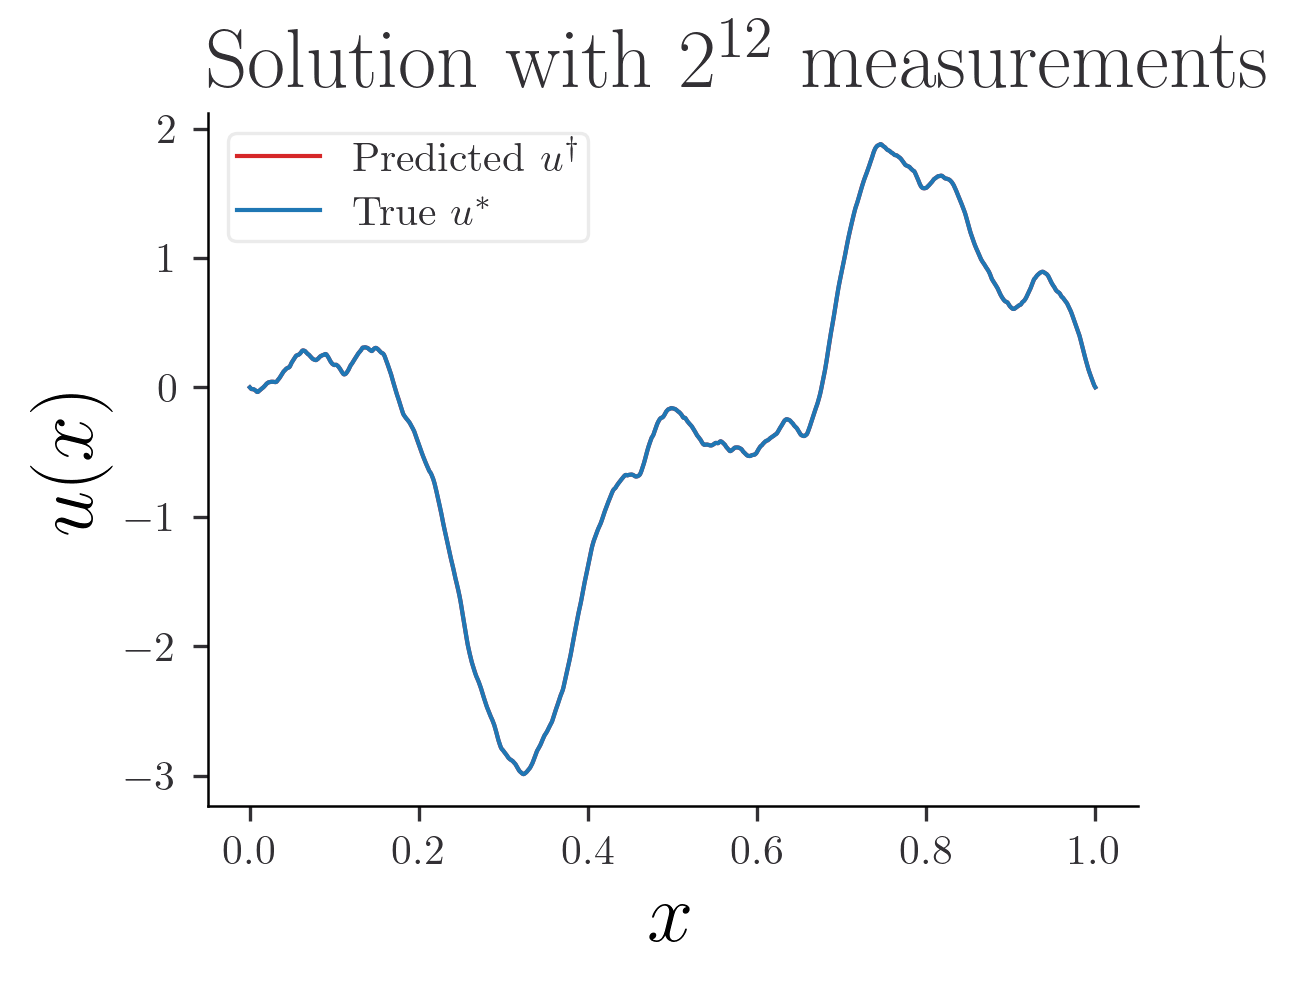

In [28]:
figure = plt.figure(figsize=(width, height))

plt.plot(domain_finest, predictions[-1], label = r"Predicted $u^\dagger$", color = 'tab:red')

plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Solution with $2^{"+str(meas_exp[-1])+"}$ measurements")
plt.legend()
plt.show()


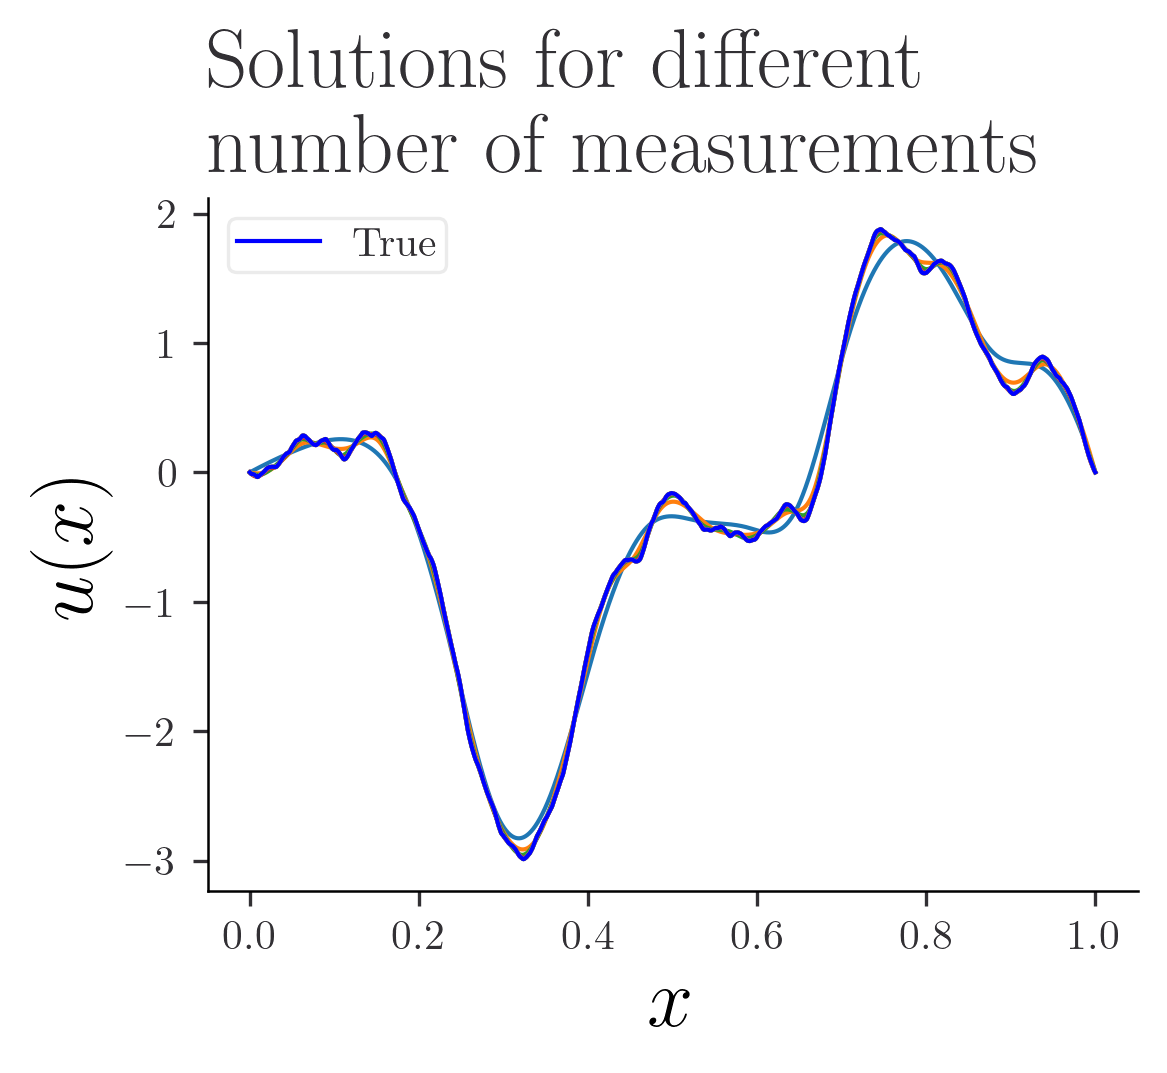

In [29]:
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp):
    plt.plot(domain_finest, predictions[i])

plt.plot(domain_finest, u_values, label = "True", color = 'blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title("Solutions for different \n number of measurements")
plt.legend()
plt.show()


In [30]:
error = jnp.array(error)
error_rel = jnp.array(error_rel)


# Estimate the convergence rate by fitting a line to the log-log plot of the error
log_n_meas = jnp.log(2**meas_exp)
log_error = jnp.log(error)

a = jnp.hstack([log_n_meas.reshape(-1, 1), jnp.ones_like(log_n_meas.reshape(-1, 1))])
b_2 = log_error
r, C = jnp.linalg.lstsq(a, b_2)[0]
r, C = -r.item(), jnp.exp(C).item()

print("L^2 Convergence rate: ", jnp.round(r,3)) 

L^2 Convergence rate:  1.3840000000000001


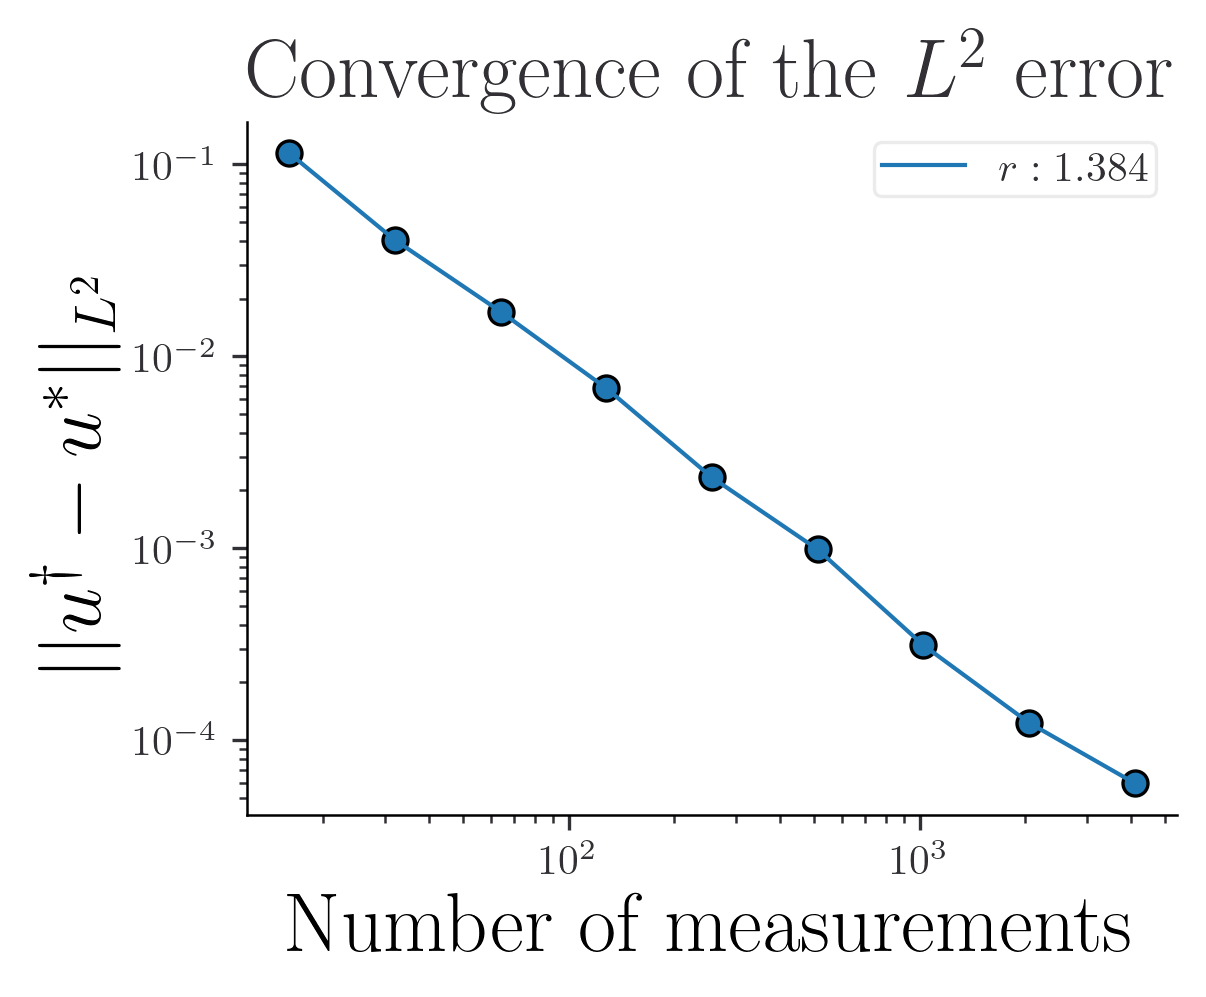

In [31]:
fig = plt.figure(figsize=(width, height))
plt.plot(2**meas_exp, error, label = r"$r :{:.03f}$".format(r))
plt.scatter(2**meas_exp, error)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Number of measurements")
plt.ylabel(r"$||u^\dagger - u^*||_{L^2}$")
plt.title(r"Convergence of the $L^2$ error")
plt.legend()

plt.show()


In [32]:
error

Array([1.14472114e-01, 4.03645668e-02, 1.70988637e-02, 6.82198186e-03,
       2.33706585e-03, 9.85577491e-04, 3.12411928e-04, 1.23102125e-04,
       5.96499472e-05], dtype=float64)

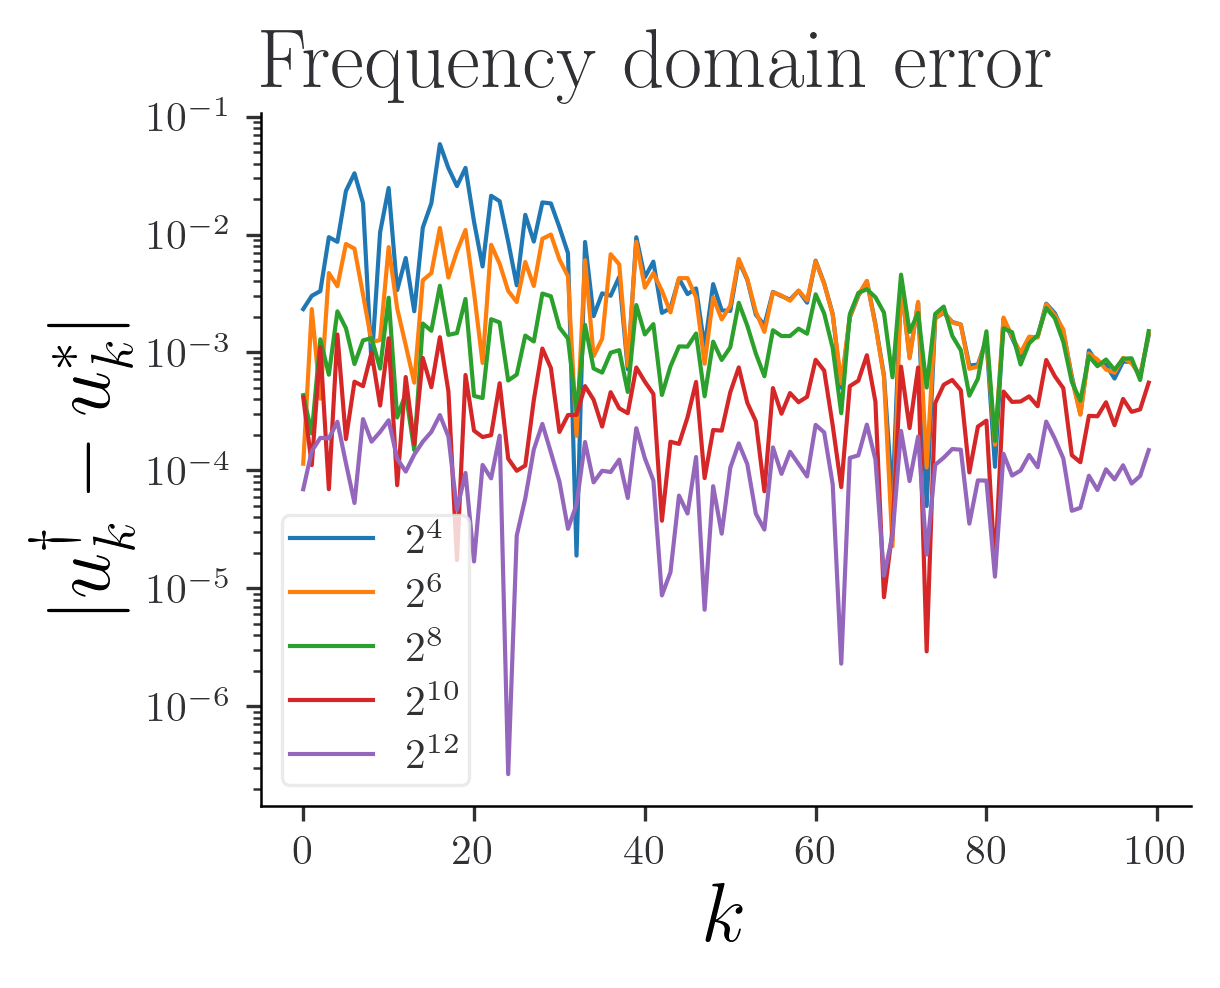

In [33]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.yscale('log')   
plt.title(r"Frequency domain error")
plt.show()


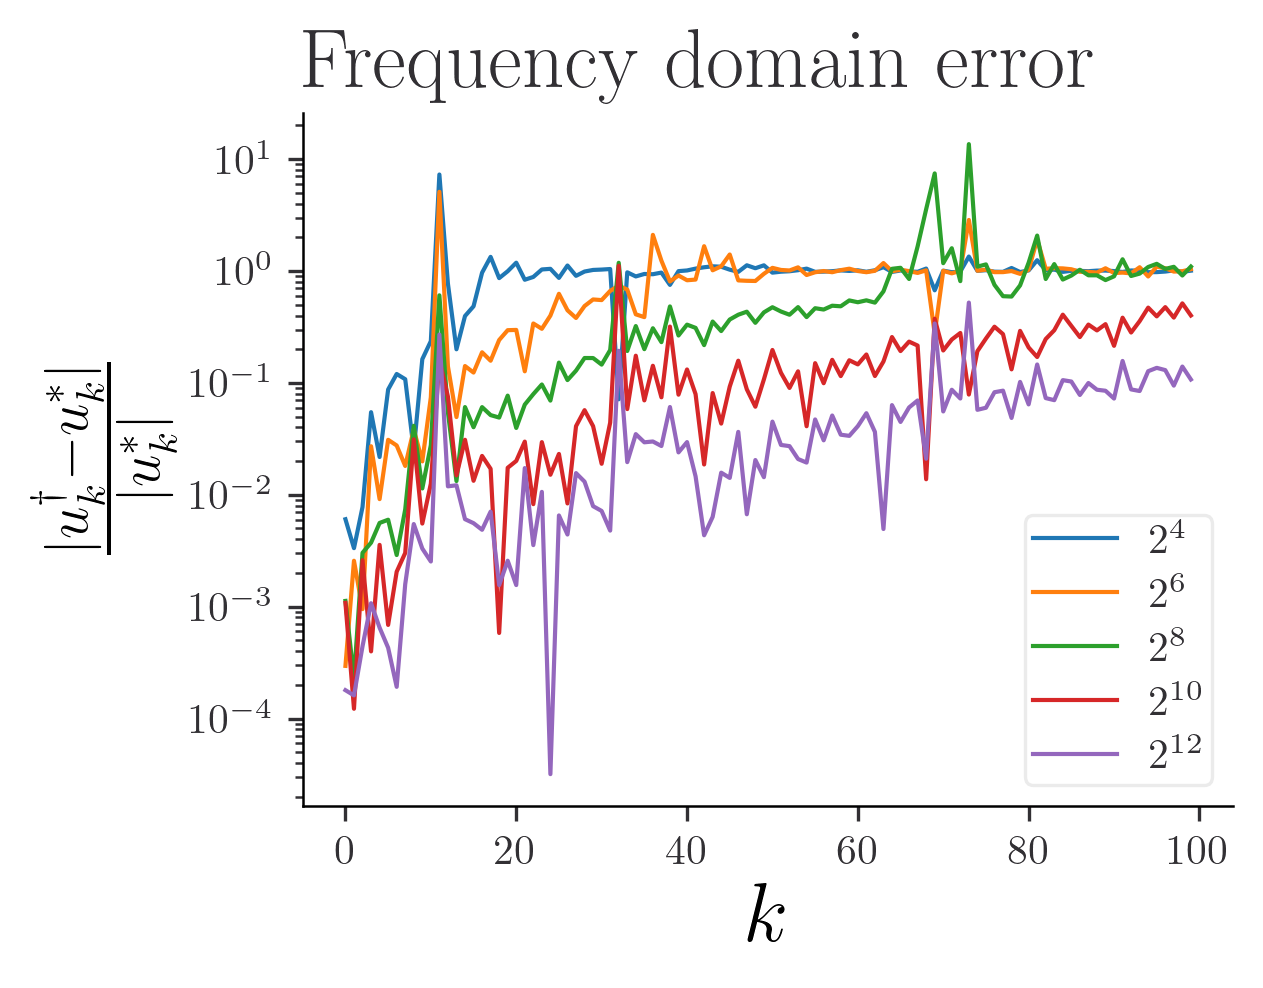

In [34]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error_rel[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.yscale('log')   
plt.title(r"Frequency domain error")
plt.show()

## Higher nugget

In [ ]:
length_scale = 1.0
error = []
error_rel = []

freq_error = []
freq_error_rel = []

reg = 1e-5


predictions = []
for i in tqdm(meas_exp):
    n_meas = 2**i
    print(n_meas)

    domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!

    # Build the kernel matrix
    theta_11 = vmap_kernel(boundary, boundary, length_scale)
    theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
    theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))

    theta_22_sine = vmap_compute_sine_coef(vmap_compute_sine_coef(theta_22).T)
    theta_22_sine = theta_22_sine
    theta_12_sine = vmap_compute_sine_coef(theta_12)
    theta_12_sine = theta_12_sine
    theta = jnp.block([[theta_11, theta_12_sine], [theta_12_sine.T, theta_22_sine]])

    rhs = jnp.concatenate([jnp.zeros_like(boundary), coef_f[:n_meas]])
    nugget = jnp.concatenate([jnp.zeros_like(boundary), reg*jnp.ones(n_meas)])
    alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a="pos") # Solve the linear system

    # Predict 
    K = vmap_kernel(domain_finest, boundary, length_scale)
    K_interior = vmap_compute_sine_coef(vmap_L_b_y(domain_finest, domain_measurements, length_scale, nu, b(domain_measurements)))
    K_interior = K_interior# remove the last spurious element
    K_eval = jnp.block([K, K_interior])
    pred = K_eval@alpha

    predictions.append(pred)

    # Computing the error in the Fourier domain
    pred_transform = compute_sine_coefficients(pred)
    L2_error = jnp.linalg.norm(pred_transform - coef_u)
    relative_L2_error = L2_error/jnp.linalg.norm(coef_u)

    error.append(L2_error)
    error_rel.append(relative_L2_error)

    error_freq = jnp.abs(pred_transform - coef_u)
    error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)
    freq_error.append(error_freq)
    freq_error_rel.append(error_freq_rel)

  0%|          | 0/9 [00:00<?, ?it/s]

16


 11%|█         | 1/9 [00:04<00:35,  4.39s/it]

32


 22%|██▏       | 2/9 [00:07<00:27,  3.88s/it]

64


 33%|███▎      | 3/9 [00:08<00:13,  2.33s/it]

128


 44%|████▍     | 4/9 [00:08<00:07,  1.59s/it]

256


 56%|█████▌    | 5/9 [00:09<00:04,  1.22s/it]

512


 67%|██████▋   | 6/9 [00:10<00:03,  1.03s/it]

1024


 78%|███████▊  | 7/9 [00:11<00:02,  1.01s/it]

2048


 89%|████████▉ | 8/9 [00:11<00:00,  1.18it/s]

4096


100%|██████████| 9/9 [00:12<00:00,  1.36s/it]


In [ ]:
error

[Array(0.13949701, dtype=float64),
 Array(0.0932947, dtype=float64),
 Array(0.08456118, dtype=float64),
 Array(0.08416973, dtype=float64),
 Array(0.08393631, dtype=float64),
 Array(0.08575984, dtype=float64),
 Array(0.08634764, dtype=float64),
 Array(0.08538047, dtype=float64),
 Array(0.0858559, dtype=float64)]

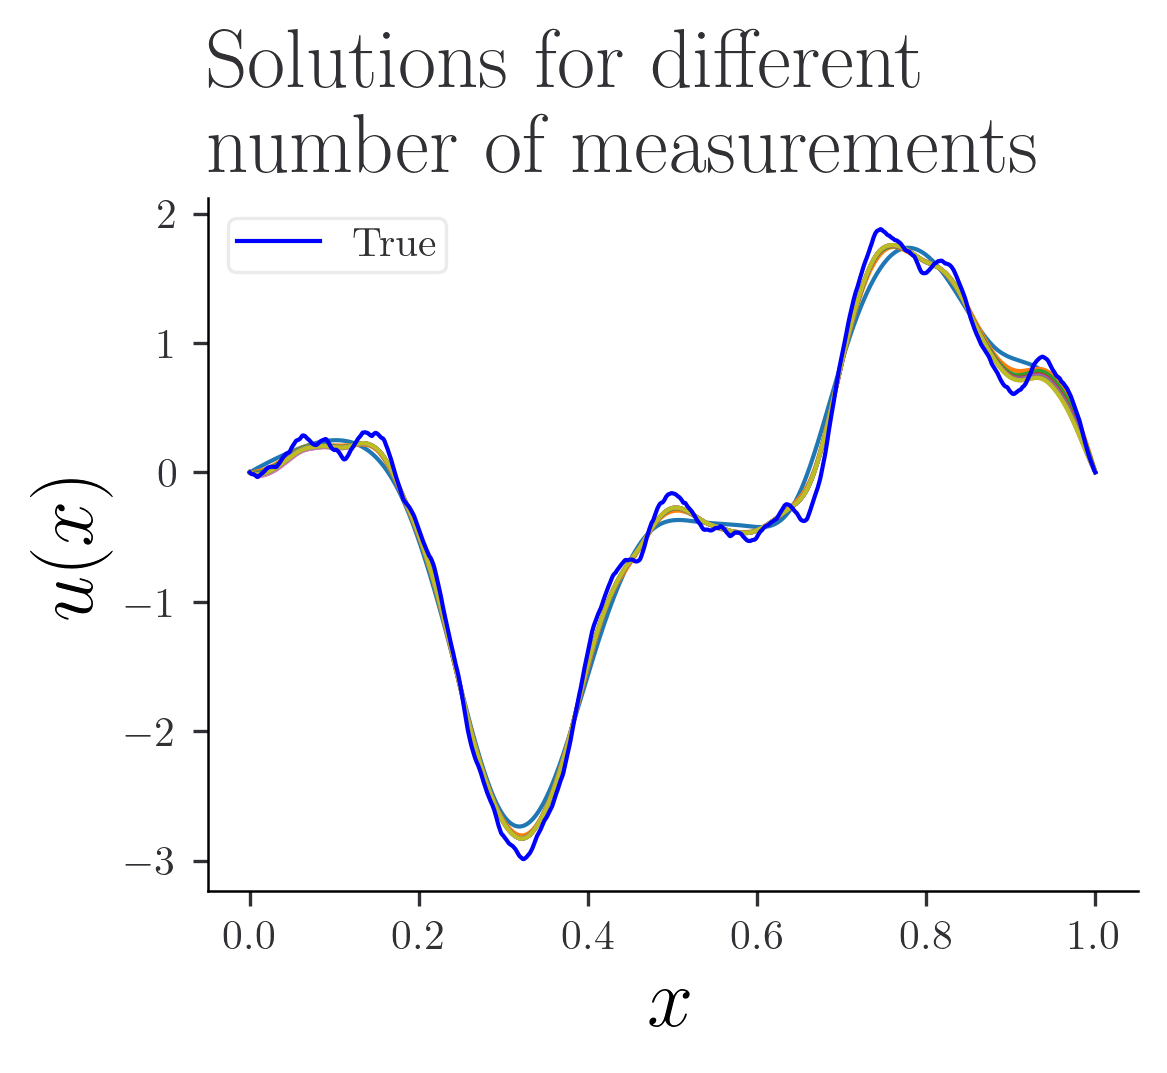

In [ ]:
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp):
    plt.plot(domain_finest, predictions[i])

plt.plot(domain_finest, u_values, label = "True", color = 'blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title("Solutions for different \n number of measurements")
plt.legend()
plt.show()


In [ ]:
error = jnp.array(error)
error_rel = jnp.array(error_rel)


# Estimate the convergence rate by fitting a line to the log-log plot of the error
log_n_meas = jnp.log(2**meas_exp)
log_error = jnp.log(error)

a = jnp.hstack([log_n_meas.reshape(-1, 1), jnp.ones_like(log_n_meas.reshape(-1, 1))])
b_2 = log_error
r, C = jnp.linalg.lstsq(a, b_2)[0]
r, C = -r.item(), jnp.exp(C).item()

print("L^2 Convergence rate: ", jnp.round(r,3)) 

L^2 Convergence rate:  0.052000000000000005


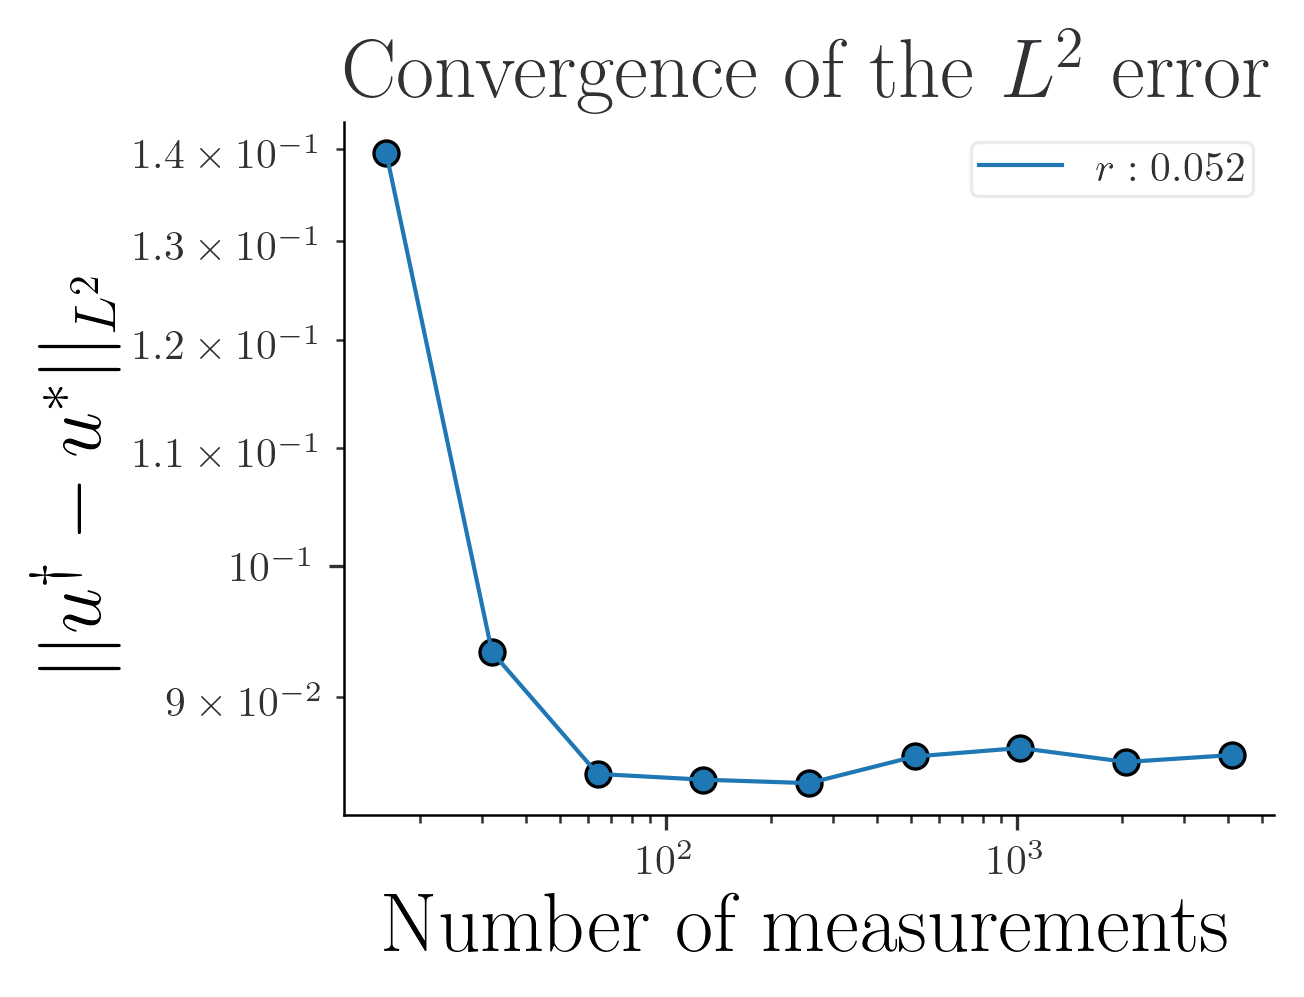

In [ ]:
fig = plt.figure(figsize=(width, height))
plt.plot(2**meas_exp, error, label = r"$r :{:.03f}$".format(r))
plt.scatter(2**meas_exp, error)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Number of measurements")
plt.ylabel(r"$||u^\dagger - u^*||_{L^2}$")
plt.title(r"Convergence of the $L^2$ error")
plt.legend()

plt.show()


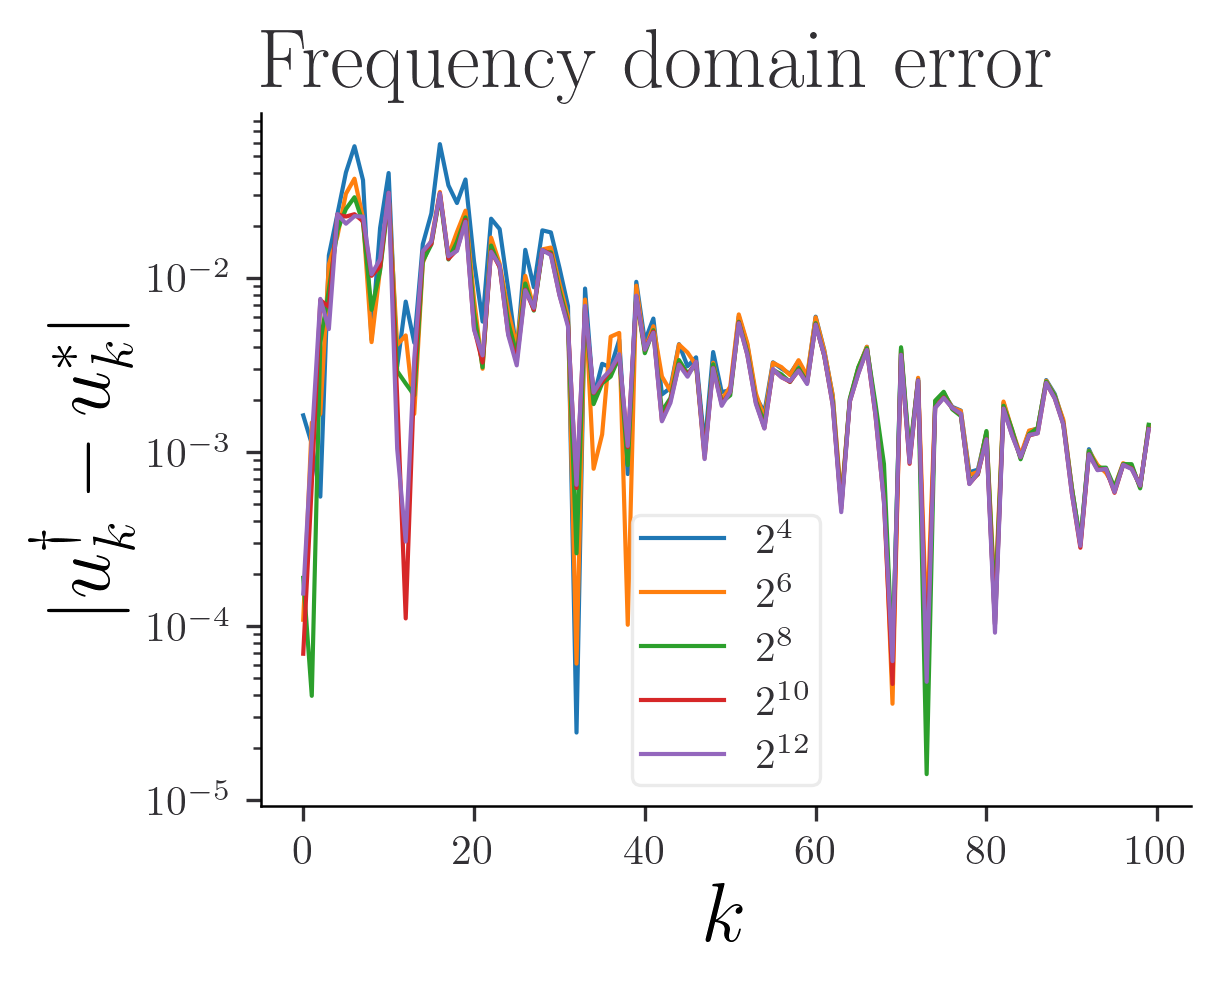

In [ ]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.yscale('log')   
plt.title(r"Frequency domain error")
plt.show()


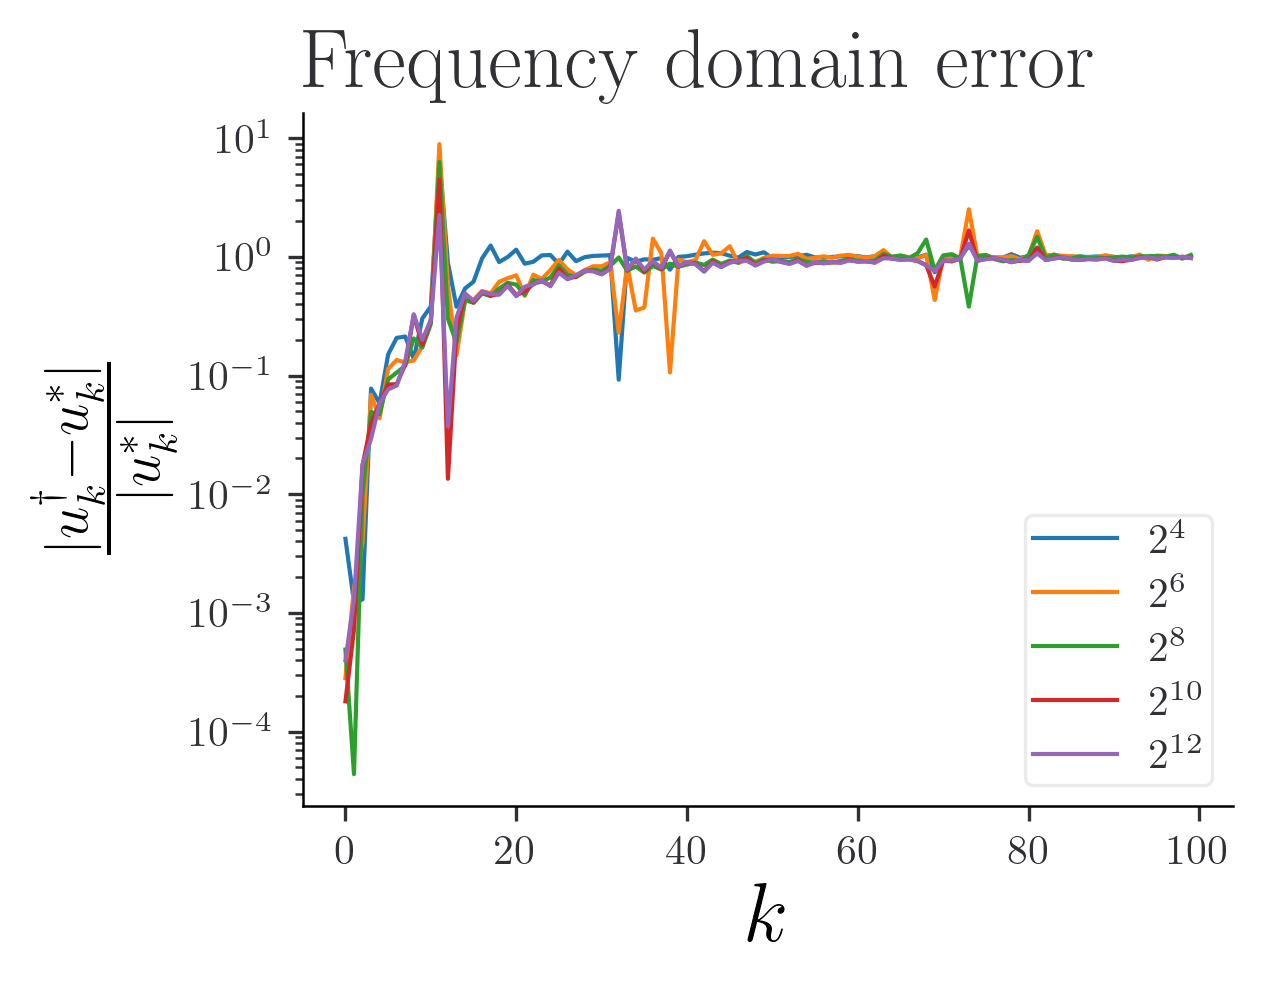

In [ ]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error_rel[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.yscale('log')   
plt.title(r"Frequency domain error")
plt.show()

## Using the $H^{-1/2}$ norm

We recall that 

$$
|| \xi||^2_{H^{-1}} = \sum_{j=1}^\infty \xi_j^2 \lambda_j^{-1/2} \propto \sum_{j=1}^\infty \xi_j^2 j^{-1}
$$

In [ ]:

length_scale = 1.0
error = []
error_rel = []

freq_error = []
freq_error_rel = []

reg = 1e-12


predictions = []

for i in tqdm(meas_exp):
    n_meas = 2**i
    print(n_meas)

    domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!

    # Build the kernel matrix
    theta_11 = vmap_kernel(boundary, boundary, length_scale)
    theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
    theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))

    theta_22_sine = vmap_compute_sine_coef(vmap_compute_sine_coef(theta_22).T)
    theta_22_sine = theta_22_sine
    theta_12_sine = vmap_compute_sine_coef(theta_12)
    theta_12_sine = theta_12_sine
    theta = jnp.block([[theta_11, theta_12_sine], [theta_12_sine.T, theta_22_sine]])

    rhs = jnp.concatenate([jnp.zeros_like(boundary), coef_f[:n_meas]])

    decay = jnp.arange(n_meas) +1
    nugget = jnp.concatenate([jnp.zeros_like(boundary), reg*decay])
    alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a="pos") # Solve the linear system

    # Predict 
    K = vmap_kernel(domain_finest, boundary, length_scale)
    K_interior = vmap_compute_sine_coef(vmap_L_b_y(domain_finest, domain_measurements, length_scale, nu, b(domain_measurements)))
    K_interior = K_interior# remove the last spurious element
    K_eval = jnp.block([K, K_interior])
    pred = K_eval@alpha

    predictions.append(pred)

    # Computing the error in the Fourier domain
    pred_transform = compute_sine_coefficients(pred)
    L2_error = jnp.linalg.norm(pred_transform - coef_u)
    relative_L2_error = L2_error/jnp.linalg.norm(coef_u)

    error.append(L2_error)
    error_rel.append(relative_L2_error)

    error_freq = jnp.abs(pred_transform - coef_u)
    error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)
    freq_error.append(error_freq)
    freq_error_rel.append(error_freq_rel)

  0%|          | 0/9 [00:00<?, ?it/s]

16


 11%|█         | 1/9 [00:00<00:04,  1.83it/s]

32


 22%|██▏       | 2/9 [00:01<00:03,  1.80it/s]

64


 33%|███▎      | 3/9 [00:01<00:03,  1.60it/s]

128


 44%|████▍     | 4/9 [00:02<00:03,  1.30it/s]

256


 56%|█████▌    | 5/9 [00:03<00:02,  1.35it/s]

512


 67%|██████▋   | 6/9 [00:04<00:02,  1.50it/s]

1024


 78%|███████▊  | 7/9 [00:04<00:01,  1.61it/s]

2048


 89%|████████▉ | 8/9 [00:05<00:00,  1.48it/s]

4096


100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


In [ ]:
error

[Array(0.11447191, dtype=float64),
 Array(0.04036404, dtype=float64),
 Array(0.01709815, dtype=float64),
 Array(0.00682099, dtype=float64),
 Array(0.00233667, dtype=float64),
 Array(0.00098591, dtype=float64),
 Array(0.00032461, dtype=float64),
 Array(0.000154, dtype=float64),
 Array(0.00011457, dtype=float64)]

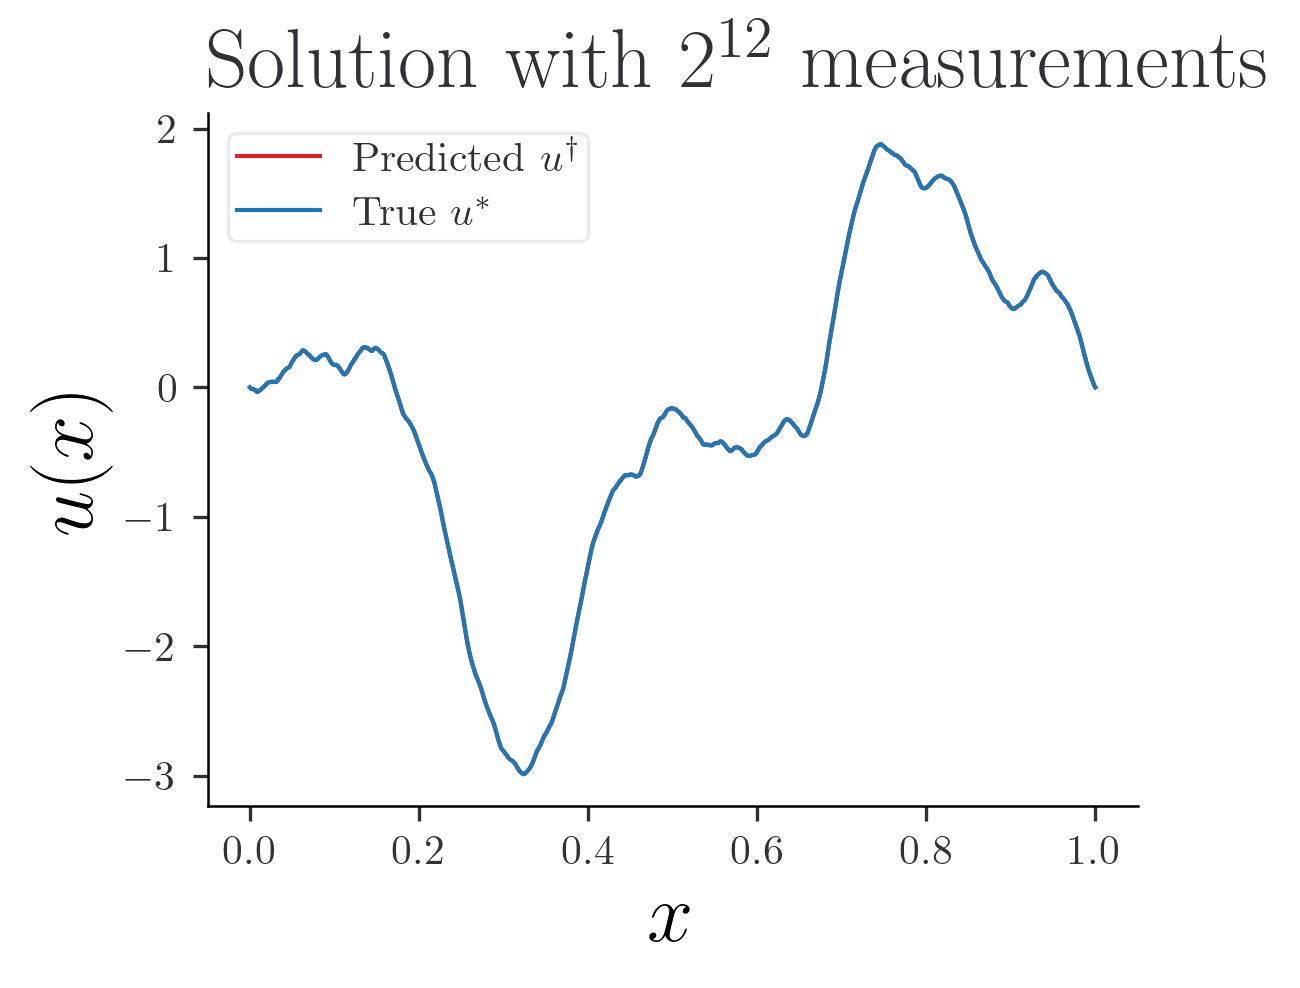

In [ ]:
figure = plt.figure(figsize=(width, height))


plt.plot(domain_finest, predictions[-1], label = r"Predicted $u^\dagger$", color = 'tab:red')

plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Solution with $2^{"+str(meas_exp[-1])+"}$ measurements")
plt.legend()
plt.show()


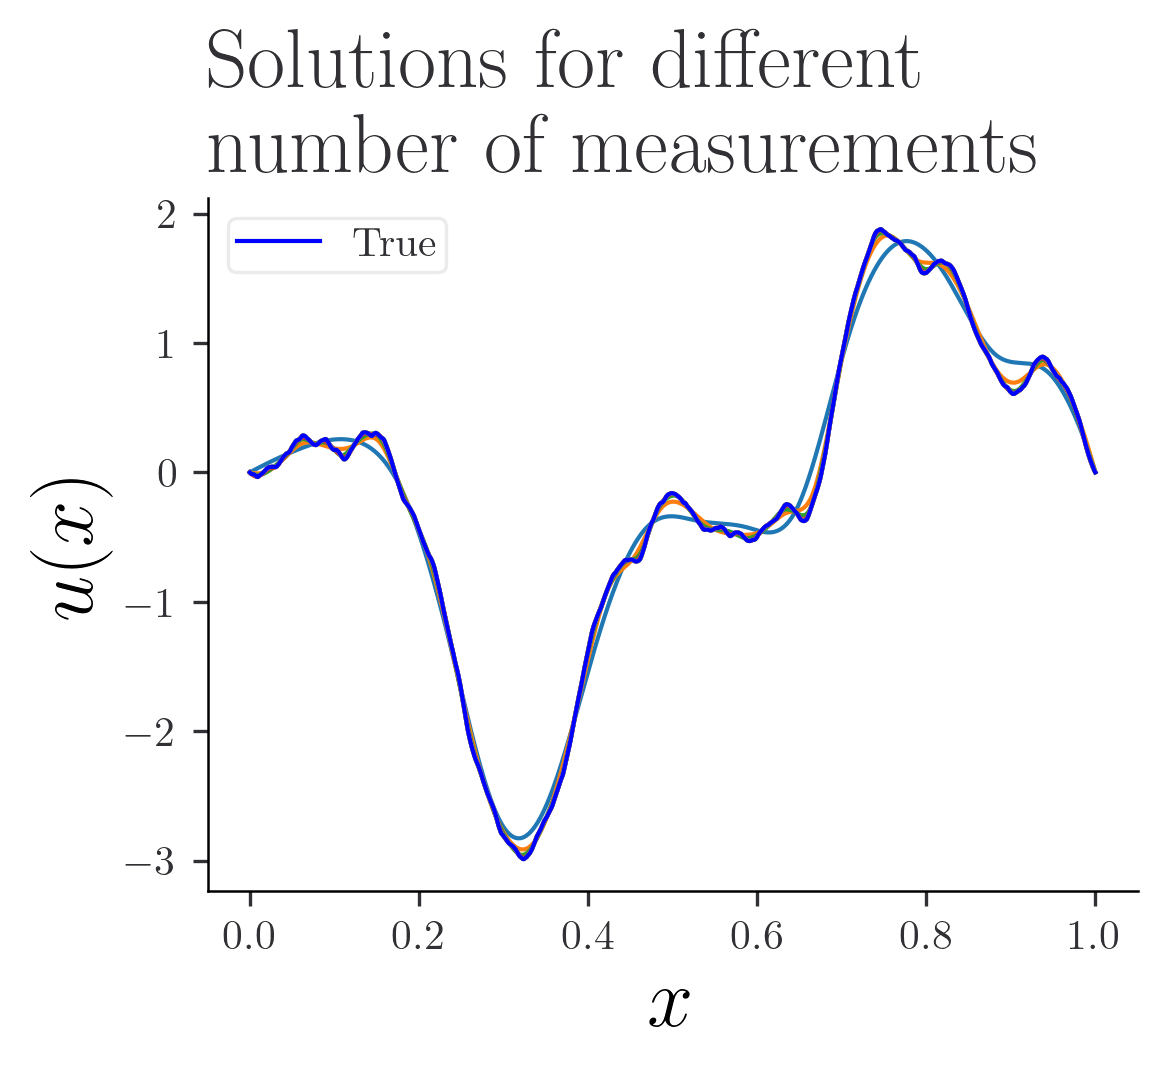

In [ ]:
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp):
    plt.plot(domain_finest, predictions[i])

plt.plot(domain_finest, u_values, label = "True", color = 'blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title("Solutions for different \n number of measurements")
plt.legend()
plt.show()


In [ ]:
error = jnp.array(error)
error_rel = jnp.array(error_rel)


# Estimate the convergence rate by fitting a line to the log-log plot of the error
log_n_meas = jnp.log(2**meas_exp)
log_error = jnp.log(error)

a = jnp.hstack([log_n_meas.reshape(-1, 1), jnp.ones_like(log_n_meas.reshape(-1, 1))])
b_2 = log_error
r, C = jnp.linalg.lstsq(a, b_2)[0]
r, C = -r.item(), jnp.exp(C).item()

print("L^2 Convergence rate: ", jnp.round(r,3)) 

L^2 Convergence rate:  1.303


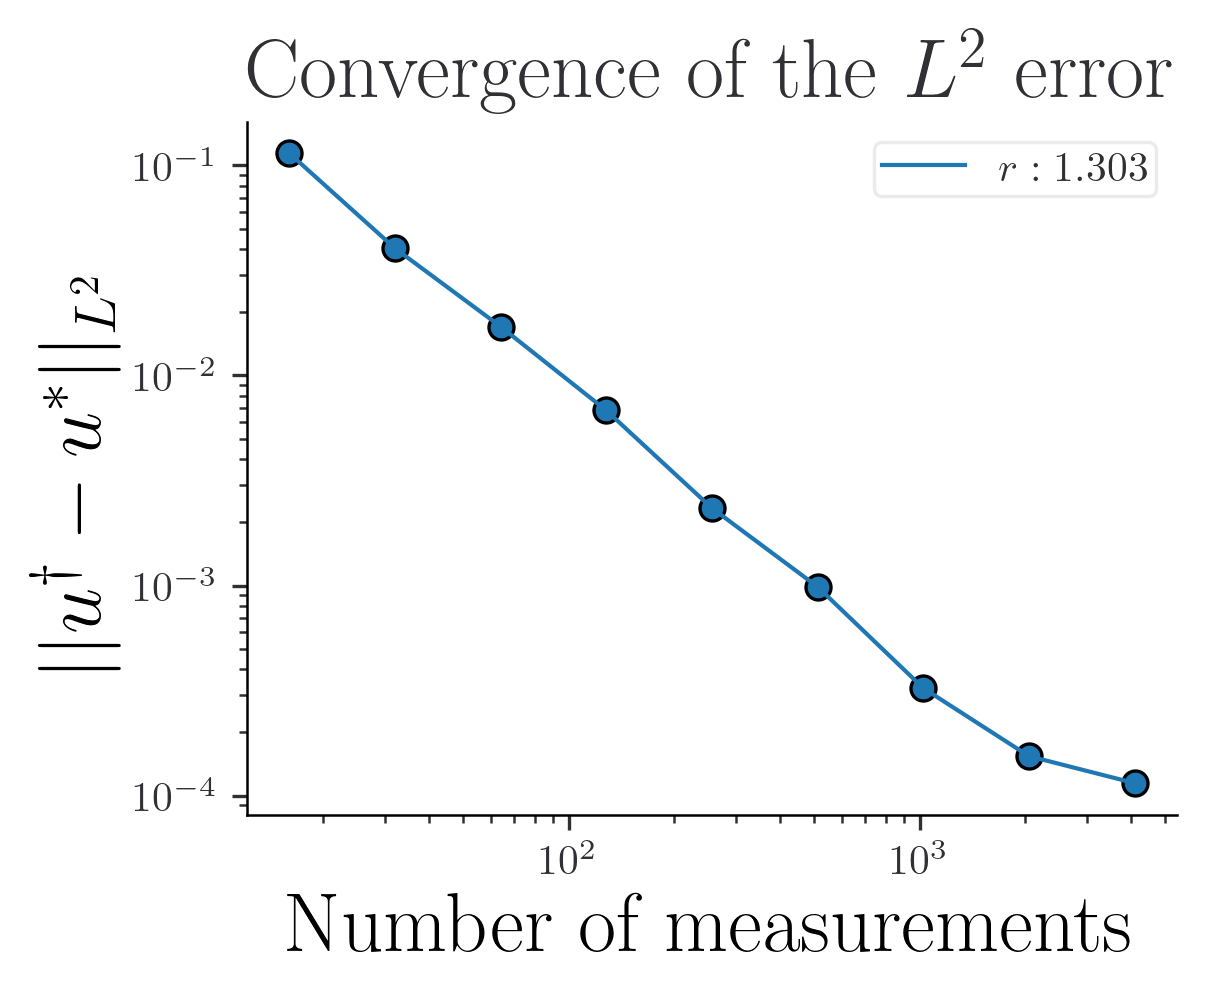

In [ ]:
fig = plt.figure(figsize=(width, height))
plt.plot(2**meas_exp, error, label = r"$r :{:.03f}$".format(r))
plt.scatter(2**meas_exp, error)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Number of measurements")
plt.ylabel(r"$||u^\dagger - u^*||_{L^2}$")
plt.title(r"Convergence of the $L^2$ error")
plt.legend()

plt.show()


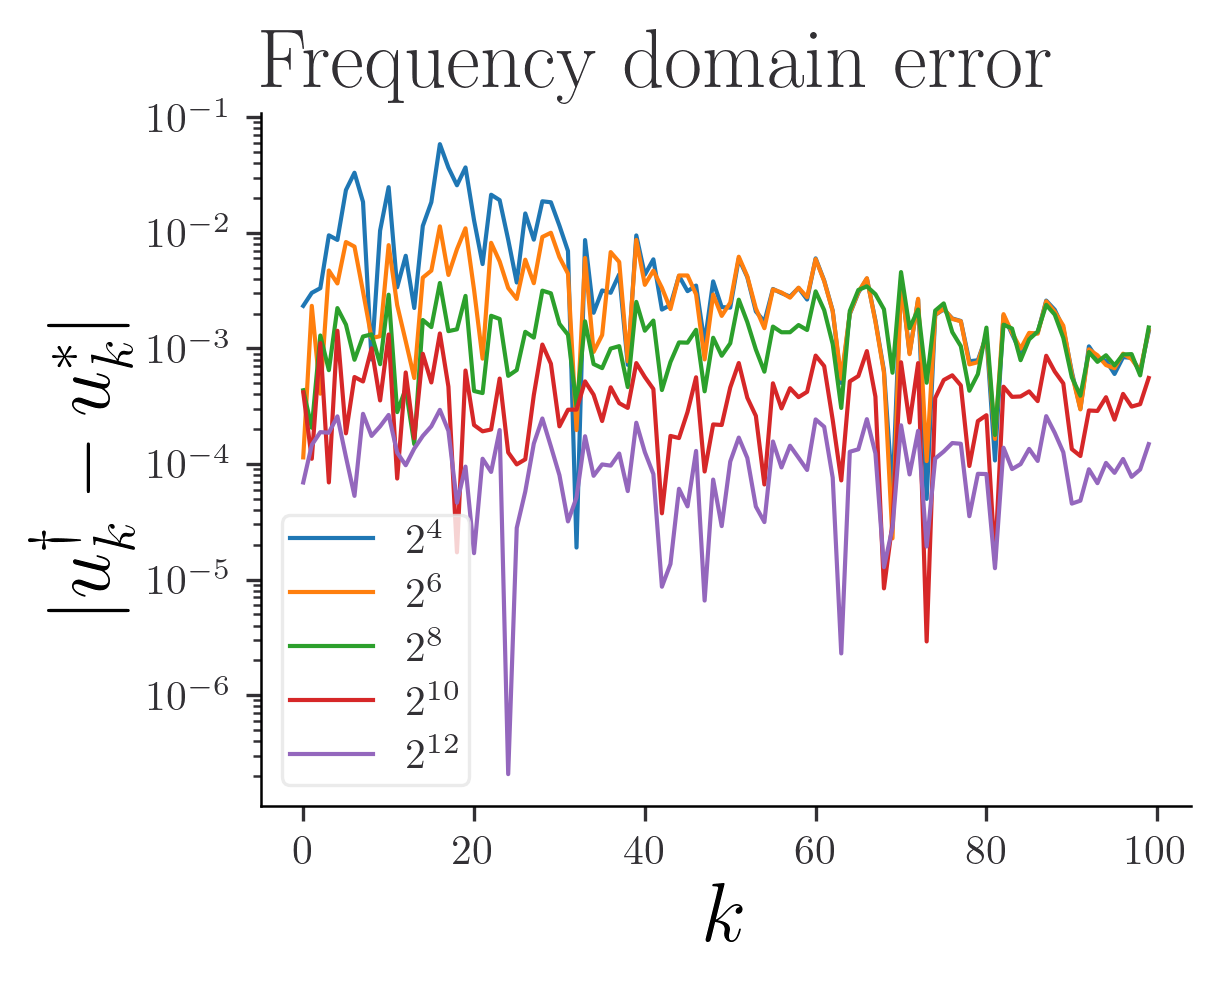

In [ ]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.yscale('log')   
plt.title(r"Frequency domain error")
plt.show()


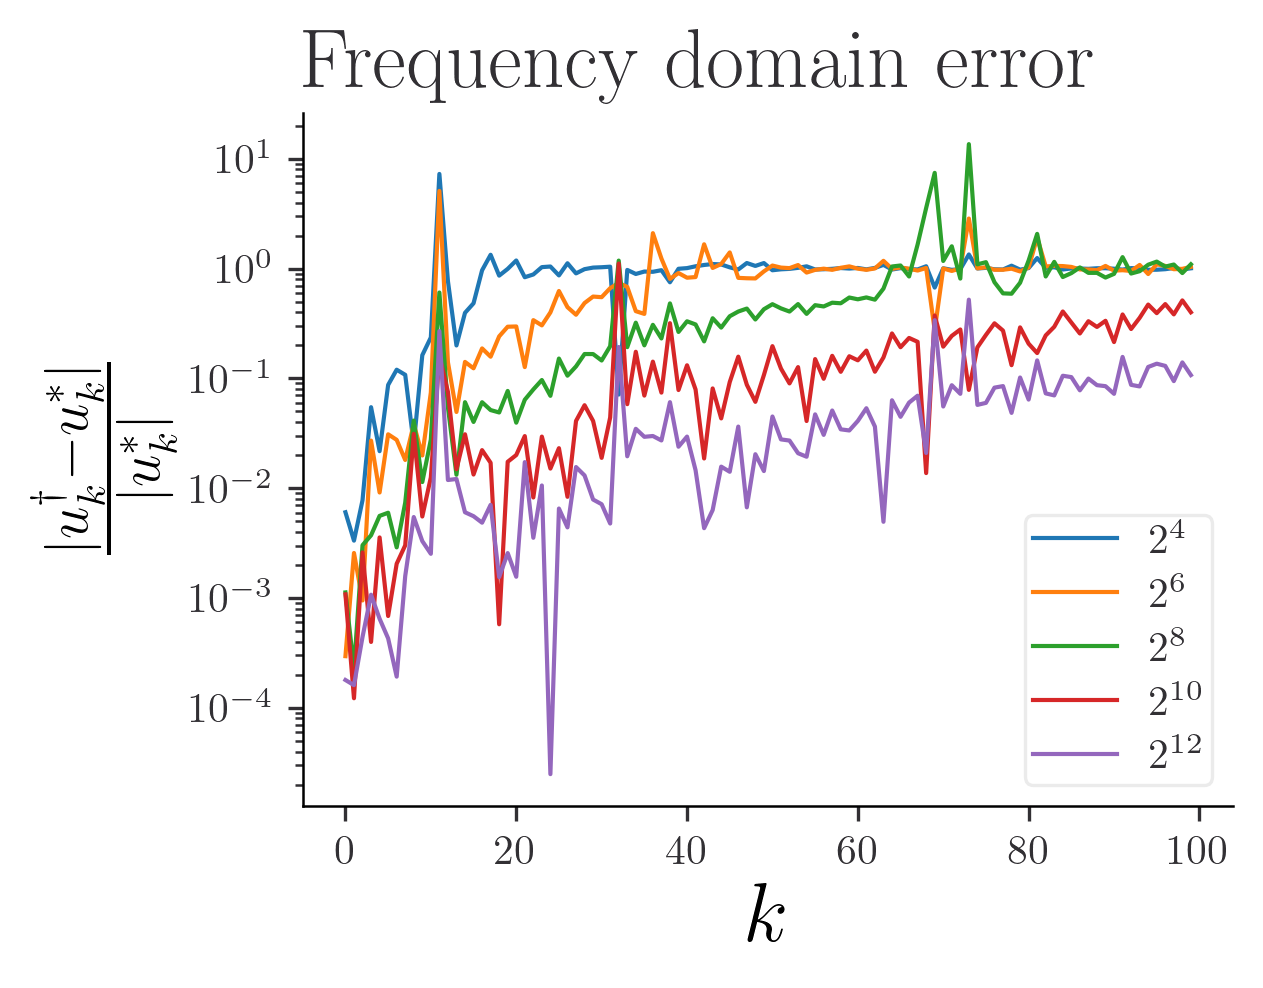

In [ ]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error_rel[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.yscale('log')   
plt.title(r"Frequency domain error")
plt.show()

## Using the $H^{-1}$ norm

We recall that 

$$
|| \xi||^2_{H^{-1}} = \sum_{j=1}^\infty \xi_j^2 \lambda_j^{-1} \propto \sum_{j=1}^\infty \xi_j^2 j^{-2}
$$

In [ ]:

length_scale = 1.0
error = []
error_rel = []

freq_error = []
freq_error_rel = []

reg = 1e-12


predictions = []

for i in tqdm(meas_exp):
    n_meas = 2**i
    print(n_meas)

    domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!

    # Build the kernel matrix
    theta_11 = vmap_kernel(boundary, boundary, length_scale)
    theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
    theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))

    theta_22_sine = vmap_compute_sine_coef(vmap_compute_sine_coef(theta_22).T)
    theta_22_sine = theta_22_sine
    theta_12_sine = vmap_compute_sine_coef(theta_12)
    theta_12_sine = theta_12_sine
    theta = jnp.block([[theta_11, theta_12_sine], [theta_12_sine.T, theta_22_sine]])

    rhs = jnp.concatenate([jnp.zeros_like(boundary), coef_f[:n_meas]])

    decay = jnp.arange(n_meas) +1
    nugget = jnp.concatenate([jnp.zeros_like(boundary), reg*decay**2])
    alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a="pos") # Solve the linear system

    # Predict 
    K = vmap_kernel(domain_finest, boundary, length_scale)
    K_interior = vmap_compute_sine_coef(vmap_L_b_y(domain_finest, domain_measurements, length_scale, nu, b(domain_measurements)))
    K_interior = K_interior# remove the last spurious element
    K_eval = jnp.block([K, K_interior])
    pred = K_eval@alpha

    predictions.append(pred)

    # Computing the error in the Fourier domain
    pred_transform = compute_sine_coefficients(pred)
    L2_error = jnp.linalg.norm(pred_transform - coef_u)
    relative_L2_error = L2_error/jnp.linalg.norm(coef_u)

    error.append(L2_error)
    error_rel.append(relative_L2_error)

    error_freq = jnp.abs(pred_transform - coef_u)
    error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)
    freq_error.append(error_freq)
    freq_error_rel.append(error_freq_rel)

  0%|          | 0/9 [00:00<?, ?it/s]

16


 11%|█         | 1/9 [00:00<00:06,  1.23it/s]

32


 22%|██▏       | 2/9 [00:01<00:06,  1.09it/s]

64


 33%|███▎      | 3/9 [00:02<00:04,  1.41it/s]

128


 44%|████▍     | 4/9 [00:02<00:03,  1.62it/s]

256


 56%|█████▌    | 5/9 [00:03<00:02,  1.69it/s]

512


 67%|██████▋   | 6/9 [00:04<00:02,  1.44it/s]

1024


 78%|███████▊  | 7/9 [00:04<00:01,  1.49it/s]

2048


 89%|████████▉ | 8/9 [00:05<00:00,  1.63it/s]

4096


100%|██████████| 9/9 [00:06<00:00,  1.45it/s]


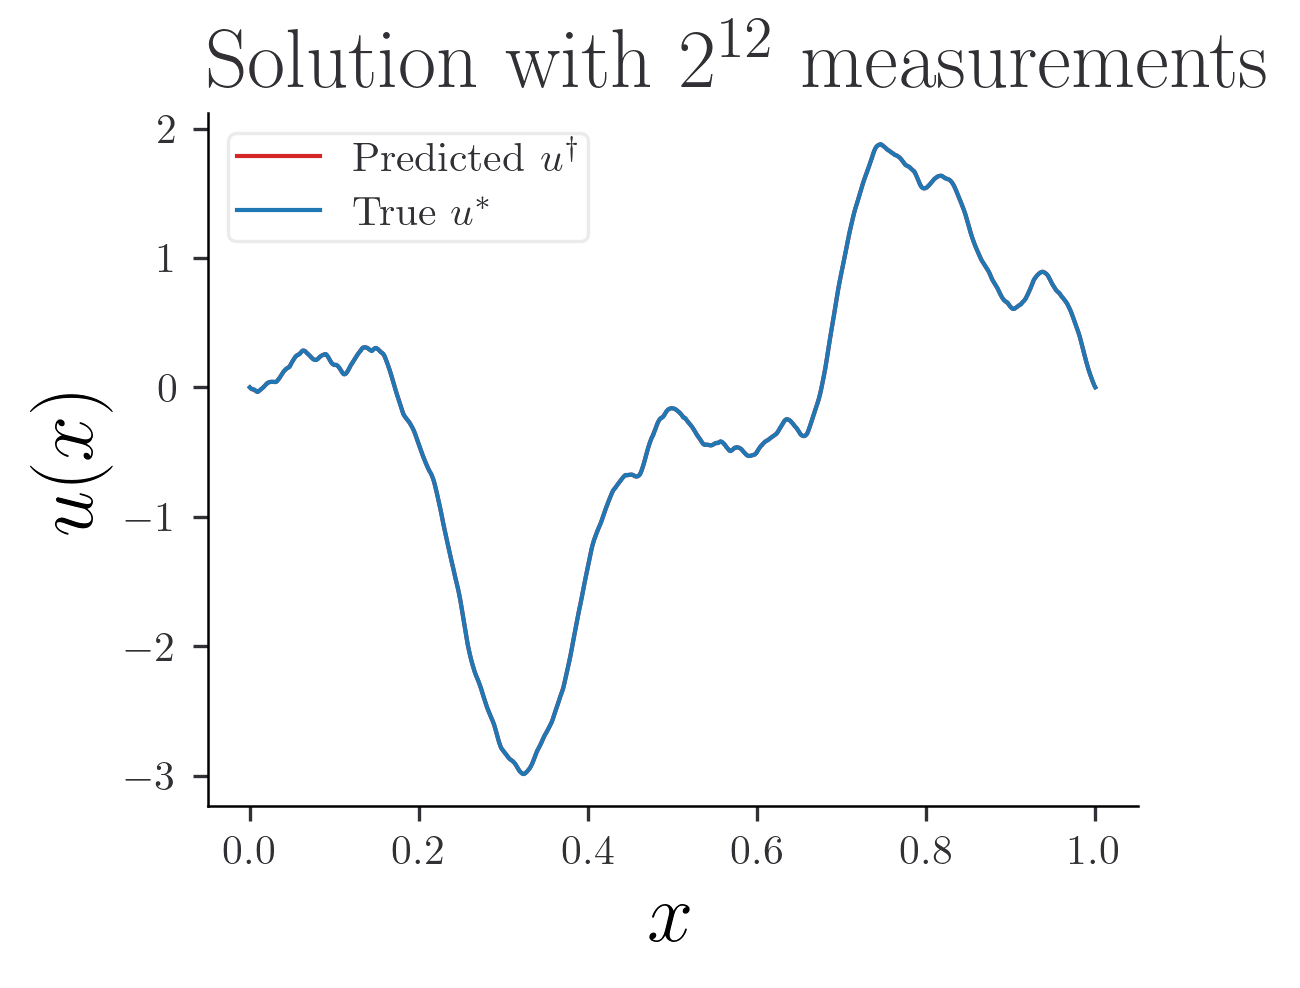

In [ ]:
figure = plt.figure(figsize=(width, height))


plt.plot(domain_finest, predictions[-1], label = r"Predicted $u^\dagger$", color = 'tab:red')

plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Solution with $2^{"+str(meas_exp[-1])+"}$ measurements")
plt.legend()
plt.show()


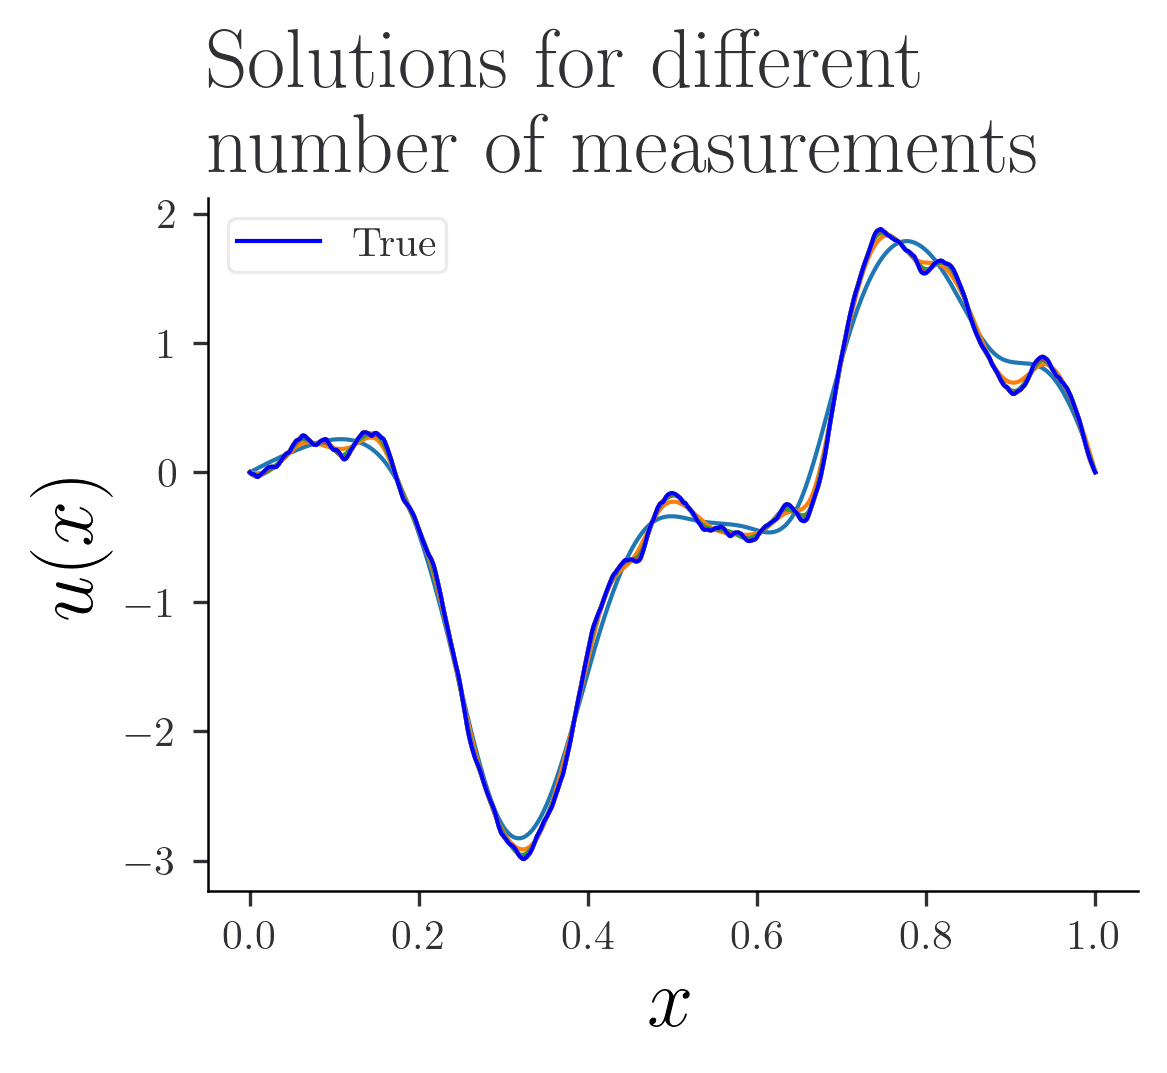

In [ ]:
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp):
    plt.plot(domain_finest, predictions[i])

plt.plot(domain_finest, u_values, label = "True", color = 'blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title("Solutions for different \n number of measurements")
plt.legend()
plt.show()


In [ ]:
error = jnp.array(error)
error_rel = jnp.array(error_rel)


# Estimate the convergence rate by fitting a line to the log-log plot of the error
log_n_meas = jnp.log(2**meas_exp)
log_error = jnp.log(error)

a = jnp.hstack([log_n_meas.reshape(-1, 1), jnp.ones_like(log_n_meas.reshape(-1, 1))])
b_2 = log_error
r, C = jnp.linalg.lstsq(a, b_2)[0]
r, C = -r.item(), jnp.exp(C).item()

print("L^2 Convergence rate: ", jnp.round(r,3)) 

L^2 Convergence rate:  0.8140000000000001


In [ ]:
error

Array([0.11447204, 0.04036608, 0.01710598, 0.0068645 , 0.00258415,
       0.00164671, 0.00147049, 0.00143784, 0.0014306 ], dtype=float64)

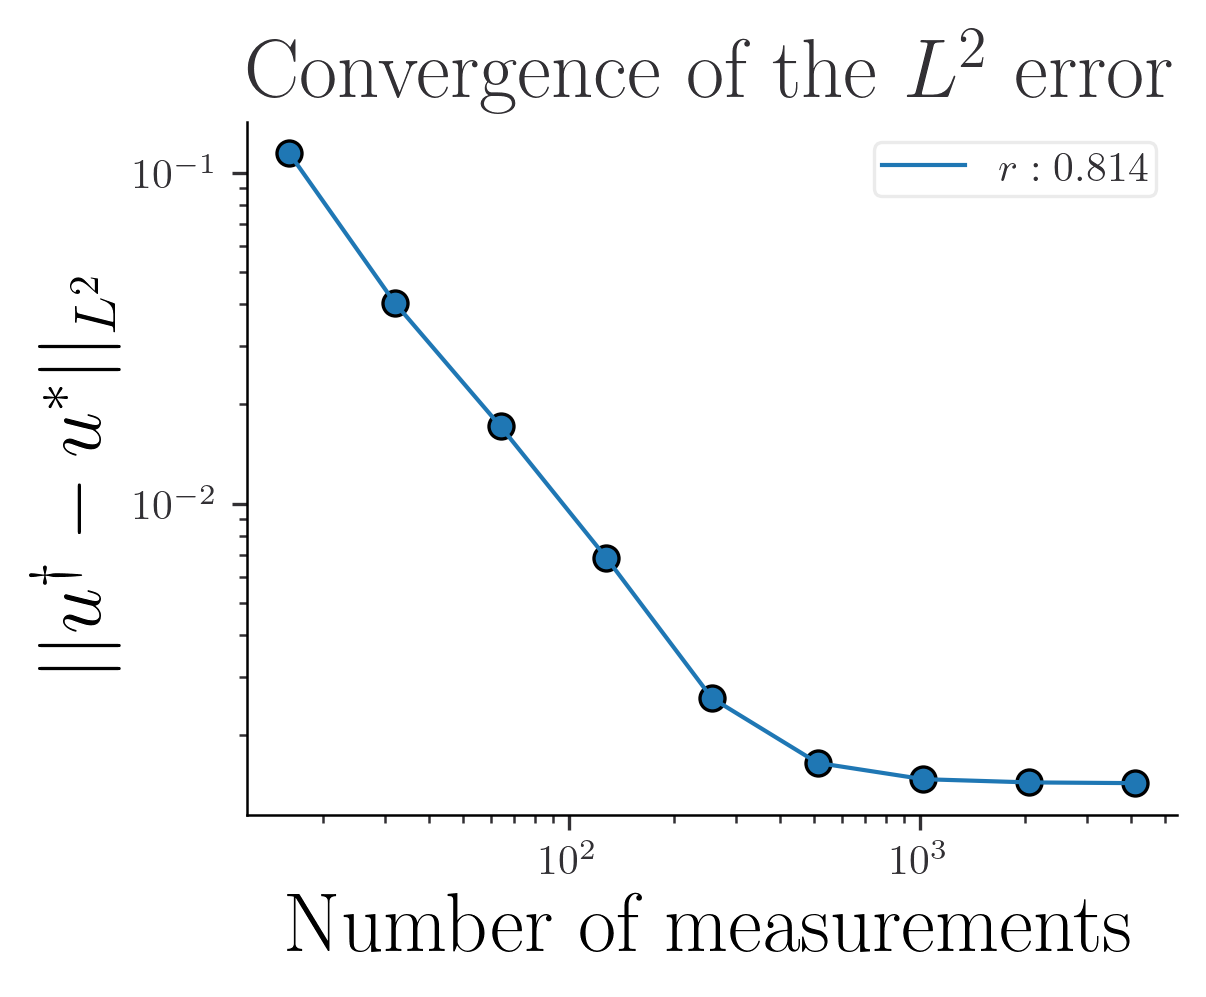

In [ ]:
fig = plt.figure(figsize=(width, height))
plt.plot(2**meas_exp, error, label = r"$r :{:.03f}$".format(r))
plt.scatter(2**meas_exp, error)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Number of measurements")
plt.ylabel(r"$||u^\dagger - u^*||_{L^2}$")
plt.title(r"Convergence of the $L^2$ error")
plt.legend()

plt.show()


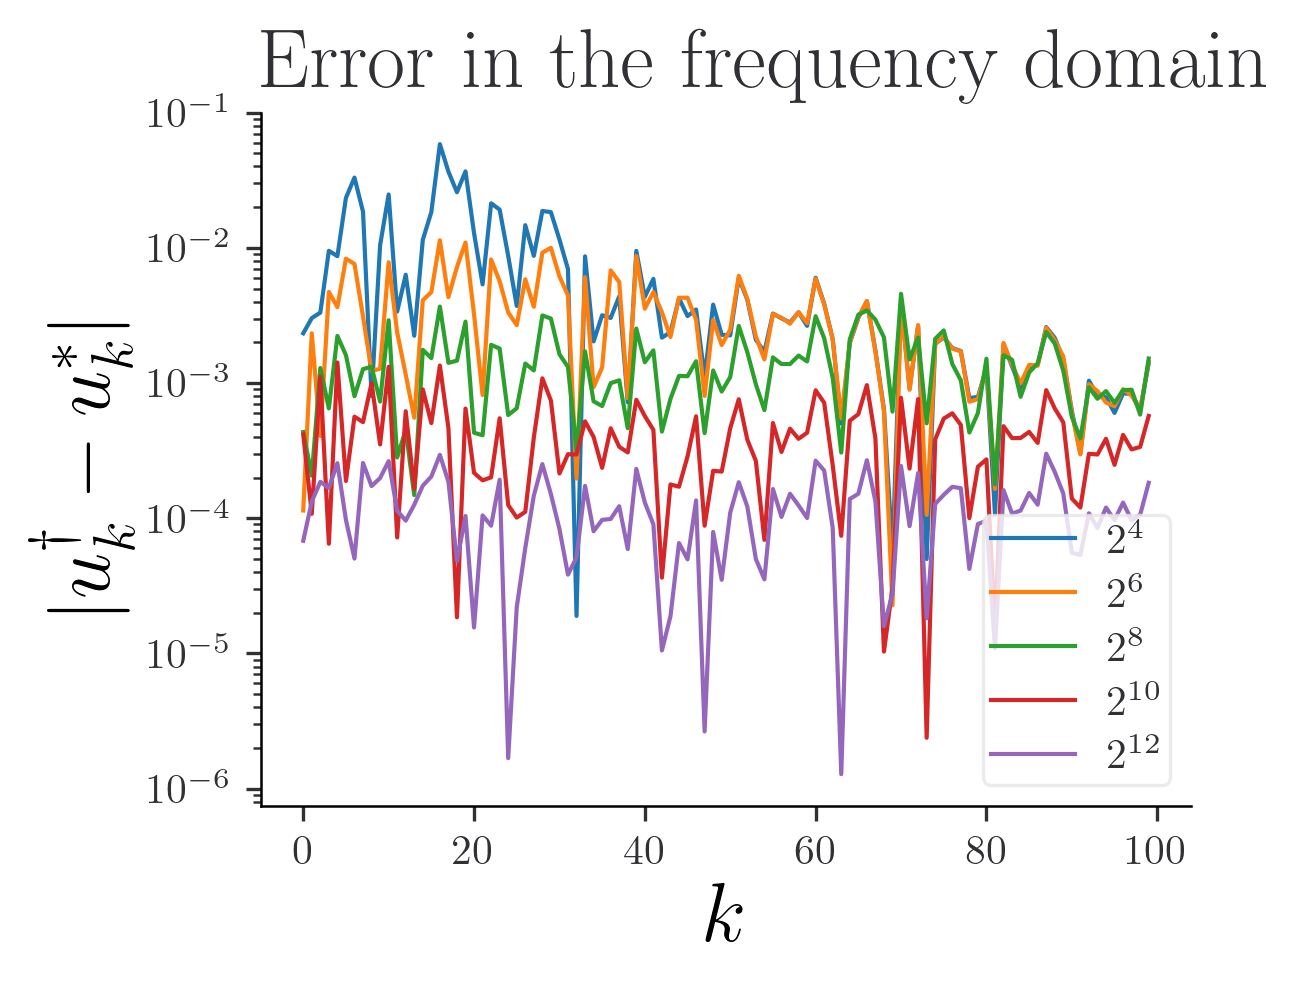

In [ ]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.yscale('log')   
plt.title(r"Error in the frequency domain")
plt.show()


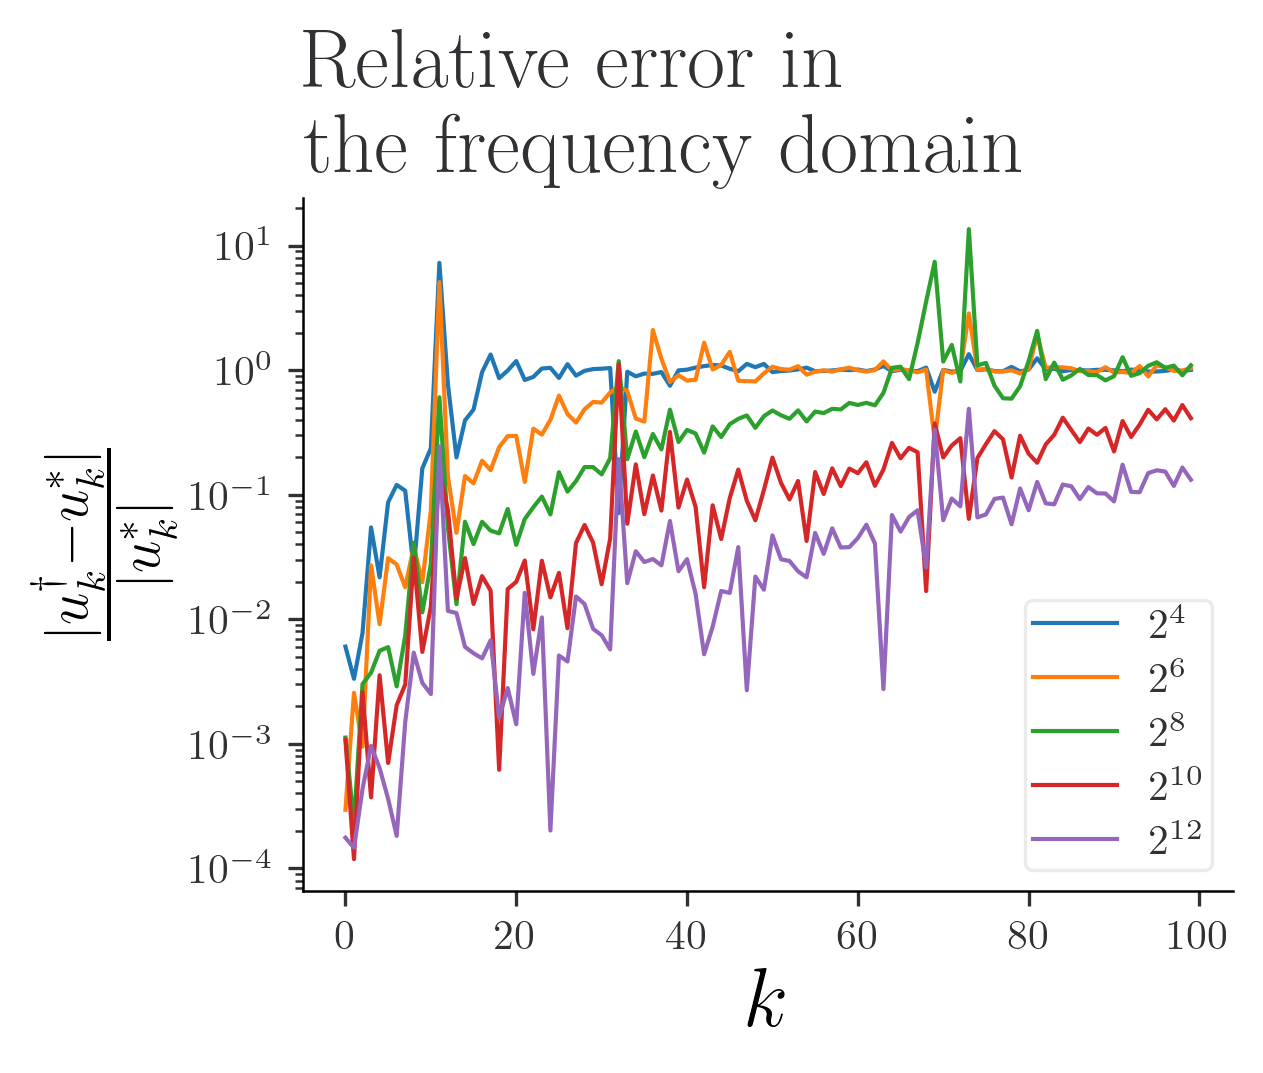

In [ ]:
# Plot the frequency error of the first 100 modes
modes_kept = 100
figure = plt.figure(figsize=(width, height))

for i,j in enumerate(meas_exp[::2]):
    plt.plot(freq_error_rel[i][:modes_kept], label = r"$2^{"+str(j)+"}$")

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.yscale('log')   
plt.title("Relative error in \n the frequency domain")
plt.show()

# Pointwise version

In [60]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
domain_measurements.shape

4096


(4096,)

In [61]:
t = 0.0
decay = jnp.arange(1, n_meas+1)**(-t/2)
decay

Array([1., 1., 1., ..., 1., 1., 1.], dtype=float64, weak_type=True)

In [62]:
length_scale = 1.0

from utils_elliptic_coef import L_b_xy, vmap_L_b_xy, vmap_L_b_y
b =lambda x : jnp.ones_like(x)*1.0

In [63]:
from importlib import reload
import utils_DST

utils_DST = reload(utils_DST)
from utils_DST import discrete_sine_transform, vmap_compute_sine_coef, compute_sine_coefficients

In [64]:
# Build the kernel matrix
theta_11 = vmap_kernel(boundary, boundary, length_scale)
theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))

theta = jnp.block([[theta_11, theta_12], [theta_12.T, theta_22]])

In [65]:
jnp.linalg.eigh(theta)[0][0]

Array(1.81927463e-06, dtype=float64)

In [66]:
f_values.shape
ratio = int(n_coef/n_meas)
f_obs = f_values[::ratio]

# plt.plot(domain_finest, f_values)
# plt.plot(domain_measurements, f_obs)

In [71]:
reg = 1e-13
rhs = jnp.concatenate([jnp.zeros_like(boundary), f_obs])
nugget = jnp.concatenate([jnp.zeros_like(boundary), reg*jnp.ones(n_meas)])
alpha = scipy.linalg.solve(theta + jnp.diag(nugget), rhs, assume_a="pos") # Solve the linear system


# Predict 
K = vmap_kernel(domain_finest, boundary, length_scale)
K_interior = vmap_L_b_y(domain_finest, domain_measurements, length_scale, nu, b(domain_measurements))
K_eval = jnp.block([K, K_interior])
pred = K_eval@alpha

In [72]:
# Computing the error in the Fourier domain
pred_transform = compute_sine_coefficients(pred)
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)

print(L2_error, relative_L2_error)


2.0966466781949977 1.6847538361618708


In [43]:
compute_1d_error(pred, u_values, domain_finest, domain_measurements)

(Array(2.09664624, dtype=float64), Array(1.68475348, dtype=float64))

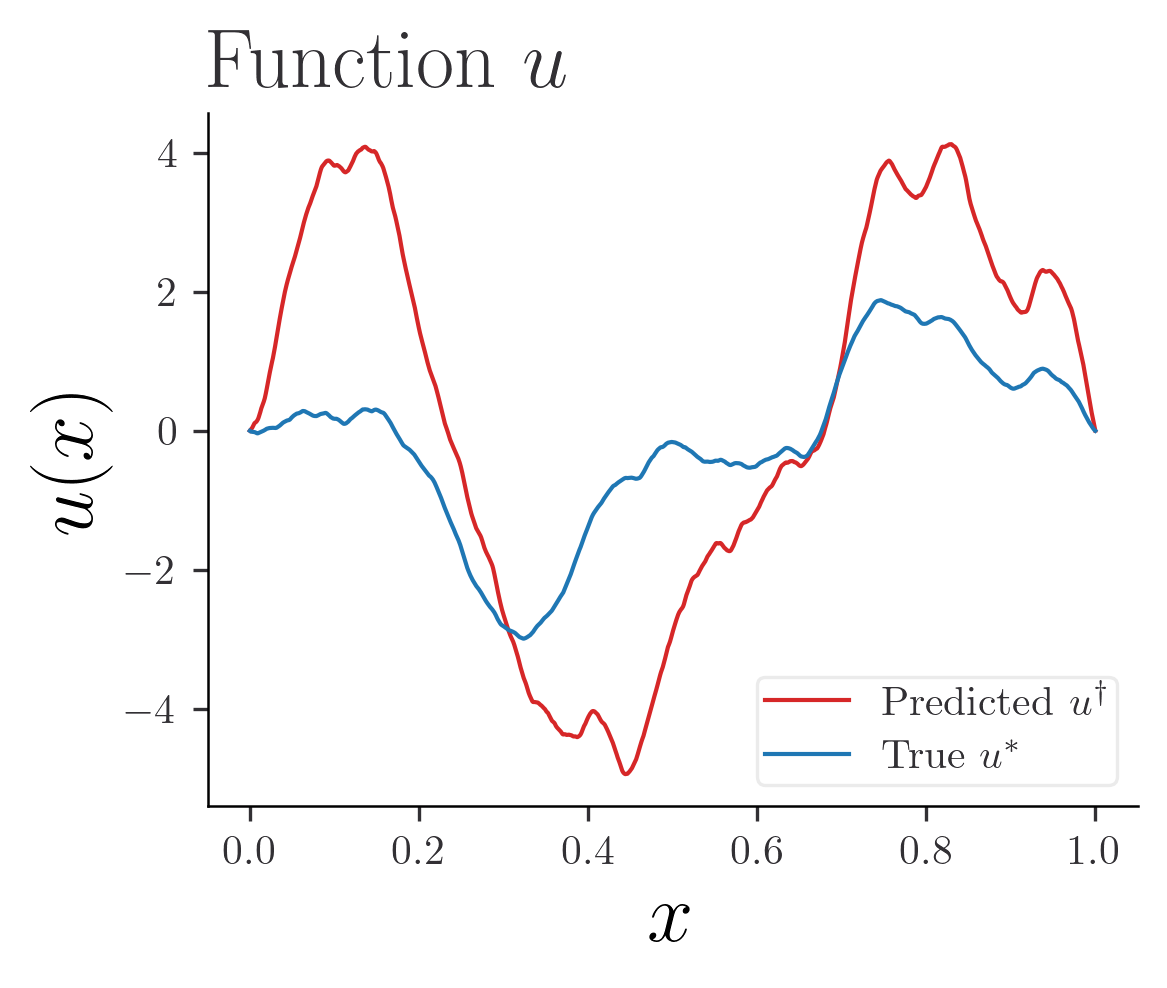

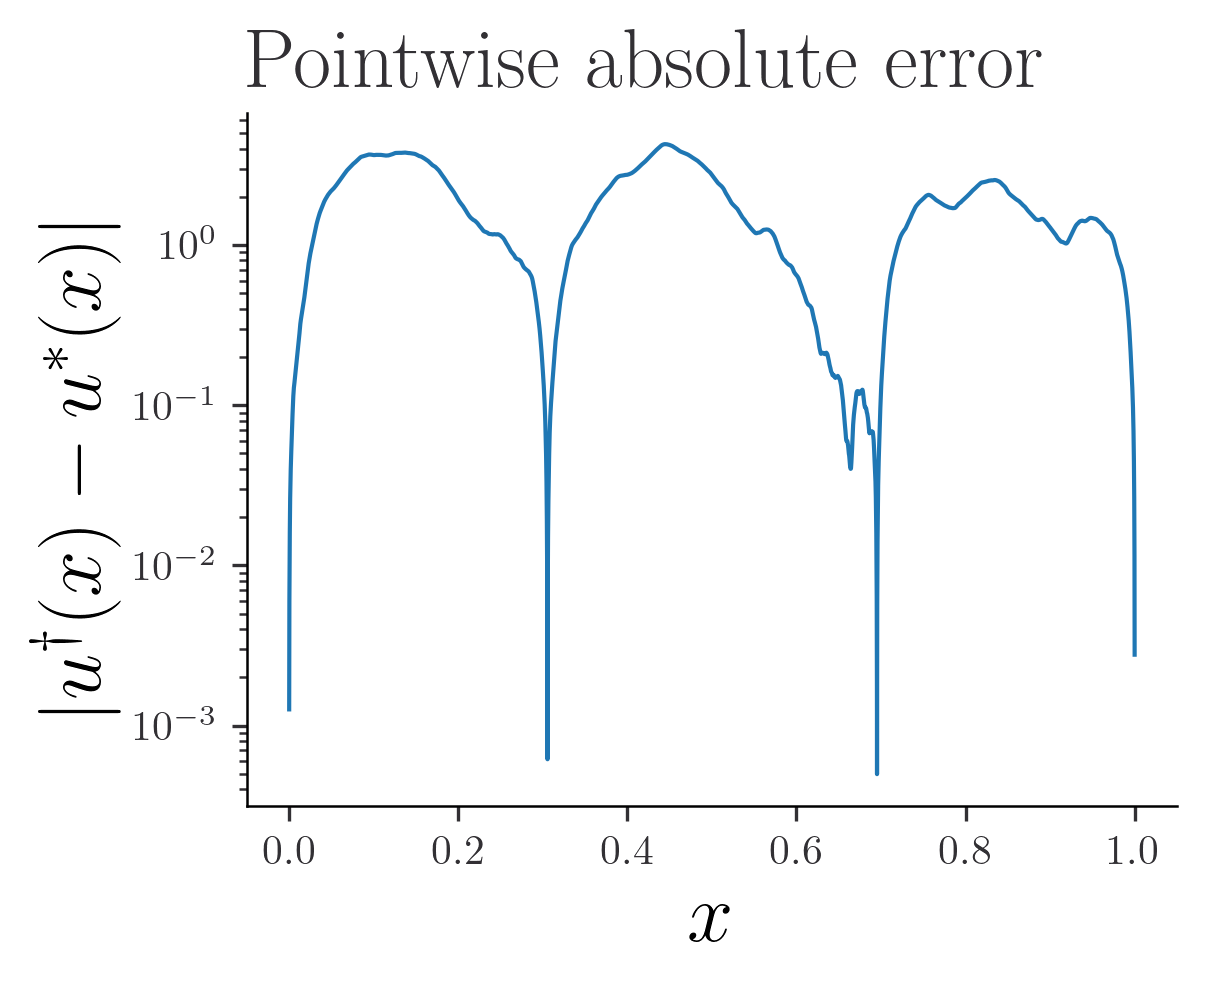

: 

In [44]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()